__Zillow housing data:__

choose the 5 best zip codes to invest in and use predictive modeling with time series

# imports, functions

In [1]:
# import libraries and tools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling
import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pmdarima as pm
%matplotlib inline
plt.style.use('fivethirtyeight')
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from numpy import log
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from math import sqrt
import chart_studio as ply
from matplotlib import pyplot
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

raw_df = pd.read_csv('zillow_data.csv')

import seaborn as sns
#from pandas.plotting import autocorrelation_plot
#from pandas import read_csv
#from datetime import datetime
# import matplotlib
#import matplotlib.dates as mdates
#from itertools import product
#from tqdm import tqdm_notebook
#import cufflinks as cf
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
#import itertools


In [2]:
# amount of times value increases    
def get_increasing_count(df):
    is_dec = df.diff().lt(0).values
    cnt = 265
    #starting_value = df.values[0]
    #result = []
    for i in range(len(is_dec)):
        if is_dec[i]:
            cnt -= 1
    return cnt

In [3]:
# rolling std, mean and adfuller test
def test_stationarity(timeseries, window=12):
    
    # rolling average mean and standard deviation
    # adfuller test with P-value
    rolmean = pd.Series(timeseries).rolling(window=window).mean()
    rolstd = pd.Series(timeseries).rolling(window=window).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    result = adfuller(timeseries)
    print('p-value: %f' % result[1])
    if result[1] <= .05:
        print('timeseries is stationary')
    else:
        print('timeseries is not stationary')

In [4]:
#time series, ACF, PACF, and dist plot
def plot_data_properties(data, lags=12):

    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title("Time Series Plot")
    plt.ylabel('Value')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=lags);
    plot_pacf(data, ax=axes[0,1], lags=lags);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

In [5]:
# plot moving average with anomolies
def plot_moving_avg(series, window=12, plot_intervals=True, scale=2, 
                      plot_anomalies=True):

#         series - dataframe with timeseries
#         window - rolling window size 
#         scale= # of std deviations from mean
#         plot_intervals - show confidence intervals
#         plot_anomalies - show anomalies 

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average")
    plt.plot(rolling_mean, "g", label="Rolling mean trend", alpha = 0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", alpha = 0.5)
        plt.plot(lower_bond, "r--", alpha = 0.5)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10, color='orange')
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [6]:
def arima_results(zip_code):
    global mod
    mod = pm.auto_arima(zip_code)
    results = mod.fit(zip_code)
    print(results.summary())

    results.plot_diagnostics(figsize=(16, 8))
    plt.show();

In [7]:
# mse, mse percent, explained variance score(this function used in auto_sarima)
def model_goodness(test, forecast):
    #mean squared error
    print('square root mean error:',(sqrt(mean_squared_error(test,forecast))))

    # percent MSE
    forecast, test = np.array(forecast), np.array(test)
    print('MSE percent:', (np.mean(np.abs(((forecast - test)/forecast)))) *100)

    #explained variance score
    print('explained variance score:',(explained_variance_score(forecast, test)))

In [8]:
# arima model plot using auto_arima, with MSE score
def auto_arima_tts(zip_code, tts_percent=.85):
    
    global mod
    
    train = zip_code[:int(tts_percent*(len(zip_code)))]
    test = zip_code[int(tts_percent*(len(zip_code))):]
    
    #building the model
    # auto_arima to find best fit for p,d,qs
    mod = pm.auto_arima(zip_code
                        ,start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True
                         #,stepwise=True
                        )
    results = mod.fit(train)
    
    #create forecast
    forecast = results.predict(n_periods=len(test))
    forecast = pd.DataFrame(forecast,index = test.index,columns=['ds'])
    
    #plot the predictions for validation set
    plt.plot(train, label='actual values(train)')
    plt.plot(test, color='green', label= 'actual values(test)')
    plt.plot(forecast,color='red',alpha=0.6, label='predicted values')
    plt.title('Train Test Split')
    plt.legend(loc="upper left")
    plt.show();
    
    model_goodness(test, forecast)

In [9]:
# # arima model plot using auto_arima, with MSE score
def auto_sarima(df, n_periods = 36):

    model=pm.auto_arima(df
                        , start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True
                        )
    # Forecast
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.plot(df)
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

    plt.title("SARIMA forecast")
    plt.show()

In [10]:
# fit to fbproph, plot, show 3 year prediction
def fb_proph(zip_code, periods=36):
    global m
    global future
    global forecast
    m = fbprophet.Prophet(interval_width=0.95
                          ,yearly_seasonality=True
                          , seasonality_mode='multiplicative'
                         )
    m.fit(zip_code.reset_index())
    future = m.make_future_dataframe(periods=periods, freq='M')
    forecast = m.predict(future)
    display(plot_plotly(m, forecast, xlabel = 'Date', ylabel = 'Price'))
    #display((forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().round()))
    global preds
    preds = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(23)

In [11]:
#MAPE score for ARIMA
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(((y_true - y_pred)/y_true))) *100

In [12]:
# get mape score for fbprophet and plot 
def proph_metrics(m, num_days= '1095 days'):
    
    df_cv = cross_validation(m
                             , horizon = num_days
                            )
    #df_cv.head()
    df_p = performance_metrics(df_cv)
    #df_p.tail()
    fig = plot_cross_validation_metric(df_cv
                                       , metric='mape'
                                      )
    #print(mean_absolute_percentage_error(df_cv.y, df_cv.yhat))
    #display(df_p.tail(1))
    #display(df_p.iloc[-12])

In [13]:
#plot predicted return if property bought at current value using predictions from fbProphet
def pred_return(cur_val, preds):
    preds.set_index('ds', inplace = True)
    preds['return'] = preds['yhat'] - cur_val
    preds['lower'] = preds['yhat_lower']- cur_val
    preds['upper'] = preds['yhat_upper']- cur_val
    preds.iloc[:, 3:].plot();
    
   # plt.plot(preds)
    plt.plot(preds.iloc[:, 3:])
    plt.fill_between(
        preds.index, 
                 preds['upper'], 
                 preds['lower'], 
                 color='k', alpha=.15)

    plt.title("predicted return")
   # plt.show()

In [14]:
#observed vs. predicted using seasonal decompose trend
def trend(ts):
    decomposition = sm.tsa.seasonal_decompose(ts)
    #fig, ax = plt.subplots();
    plt.figure(figsize=(16,4))
    plt.title("observed values and trend")
    plt.ylabel('Value')
    plt.xlabel('Year')
    #sm.tsa.seasonal_decompose(ts);
    plt.plot(decomposition.trend.index, decomposition.trend, c='red', linewidth=5, alpha= 0.7);
    plt.plot(ts.index, ts, c='blue', linewidth=3);

# explore, scrub

Zillow's housing records data:

In [15]:
df = pd.read_csv('zillow_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

Data has 272 columns being dates(from 1996-2018), and the rest describing the location, with a total of 14723 records.

In [16]:
# #isolating non-date data for pandas_profiling
pandas_profiling.ProfileReport(df.iloc[:,0:7])

Being somewhat familiar with zip codes, I'm able to identify the RegionName column as zip codes, but unsure of RegionID. 

Curious how the states compare.

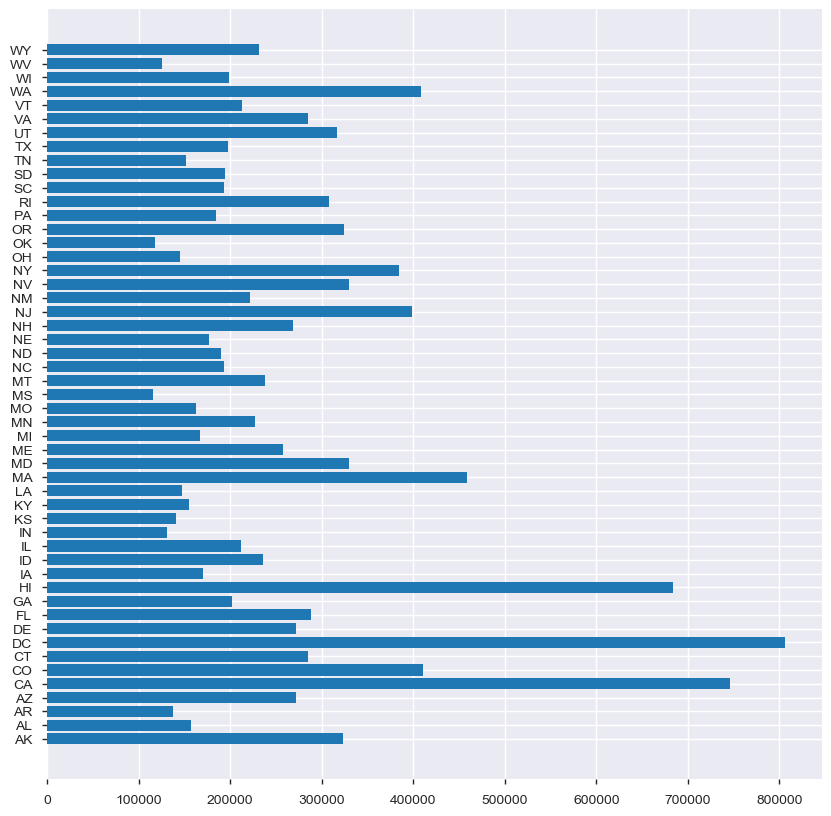

In [17]:
state_avg = raw_df.groupby('State').mean()
plt.figure(figsize=(10,10))
plt.barh(state_avg.index, state_avg['2018-04']);

The locations appear to cover all US states(including D.C.) and cities.\
DC, California, and Hawaii hold the highest average home prices as of 2018, but this doesn't necessarily mean the top zip codes will be amongst those.


The goal is to find the top 5 zip codes, so other columns are removed from df.

In [18]:
#remove unneeded columns
cols_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
df = df.drop(cols_drop, axis=1)

# convert RegionName values to string and as index
df['RegionName'] = df['RegionName'].astype(str)
df.set_index('RegionName', inplace = True)
df.head()

1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
RegionName                                                               
60657       334200.0  335400.0  336500.0  337600.0  338500.0  339500.0   
75070       235700.0  236900.0  236700.0  235400.0  233300.0  230600.0   
77494       210400.0  212200.0  212200.0  210700.0  208300.0  205500.0   
60614       498100.0  500900.0  503100.0  504600.0  505500.0  505700.0   
79936        77300.0   77300.0   77300.0   77300.0   77400.0   77500.0   

             1996-10   1996-11   1996-12   1997-01  ...  2017-07  2017-08  \
RegionName                                          ...                     
60657       340400.0  341300.0  342600.0  344400.0  ...  1005500  1007500   
75070       227300.0  223400.0  219600.0  215800.0  ...   308000   310000   
77494       202500.0  199800.0  198300.0  197300.0  ...   321000   320600   
60614       505300.0  504200.0  503600.0  503400.0  ...  1289800  1287700   
79936        77600.0   77700.0   77700.0   77800.0  ...   119100   119400   

            2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
RegionName                                                                  
60657       1007800  1009600  1013300  1018700  1024400  1030700  1033800   
75070        312500   314100   315000   316600   318100   319600   321100   
77494        320200   320400   320800   321200   321200   323000   326900   
60614       1287400  1291500  1296600  1299000  1302700  1306400  1308500   
79936        120000   120300   120300   120300   120300   120500   121000   

            2018-04  
RegionName           
60657       1030600  
75070        321800  
77494        329900  
60614       1307000  
79936        121500  

[5 rows x 265 columns]

## Dealing will null values

In [19]:
# check for missing data(percent)
df.isnull().sum().sum()/(14723*272)

0.03917714779996084

It appears there's close to 4% of cells with missing data.

I'd like to avoid eliminating rows with insignificant amounts of missing values if possible.\
Looking at what percentage of rows are missing significant amounts data to see what I'm working with:

In [20]:
for num, perc in zip((0.0, 0.1, 0.25, 0.5, 0.75, 0.9), ('any','10%', '25%','50%', '75%', '90%')) :
    print('\n % of rows with more than',perc,'missing values:')
    len(df[df.isna().mean(axis=1) > num])/ len(df)


 % of rows with more than any missing values:


0.07056985668681655


 % of rows with more than 10% missing values:


0.07036609386673912


 % of rows with more than 25% missing values:


0.07036609386673912


 % of rows with more than 50% missing values:


0.042110982816002174


 % of rows with more than 75% missing values:


0.013991713645316851


 % of rows with more than 90% missing values:


0.0

7 percent of rows are missing more than 1/4 of values. 
I'm curious if the data is missing mostly from the earlier years, later years, or if there are values missing randomly scattered throughout the dataframe, so I can figure out how to manage the null values.\
I might consider using ffill or bfill(or average of ffill + bfill) if the nas are scattered and sparse. 

In [21]:
#rows with any missing data
df[df.isnull().any(axis=1)]

1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  \
RegionName                                                                  
10011           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10456           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
60611           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11238           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27834           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10021           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58103           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2301            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
67401           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10014           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
35758           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58104           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
57106           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30032           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58201           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
72764           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
70301           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30721           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
31061           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11101           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
49442           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10459           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11205           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30120           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11217           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
45385           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
46203           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
94608           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
64804           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
35630           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...             ...      ...      ...      ...      ...      ...      ...   
44449           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24325           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
72845           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58042           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
66956           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
33855           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
19964           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
62440           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
67070           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
37141           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
93664           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
66023           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
31561           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
43013           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
56041           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
57035           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
49638           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
56010           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
68633           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
93529   

There are 1039 rows with nas, and it looks like the missing values are primarily, if not all, in the earlier months of the time series.\
What if I were to limit data to the most recent 15 or even 10 years?

In [22]:
# rows missing data after 2004
len(df.iloc[:,108:][df.iloc[:,108:].isnull().any(axis=1)])
# rows missing after 2008
len(df.iloc[:,168:][df.iloc[:,168:].isnull().any(axis=1)])

801

349

Even excluding half of the time span doesn't eliminate the nas to, so I may need to figure something else out.

I'm still hesitant to drop so many rows. Some of the rows with missing data end with pretty high values, therefore may be considered as one of the top zip codes for investment. There's less risk of missing one of the 'better' zip codes if only dropping the lower priced ones.


Looking at the percentiles of current zip code values and recent value increases could help establish a cut off point for zip codes included in the consideration for top 5:

In [23]:
# values as of 2018-04
print('prices in 2018:')
round(df['2018-04'].describe())

# price difference between 2018-2011
print('return from 2011 to 2018:')
round((df['2018-04']-df['2011-04']).describe())

prices in 2018:


count       14723.0
mean       288040.0
std        372054.0
min         13800.0
25%        132400.0
50%        198100.0
75%        321100.0
max      17894900.0
Name: 2018-04, dtype: float64

return from 2011 to 2018:


count      14448.0
mean       85424.0
std       163470.0
min      -155200.0
25%        20700.0
50%        43800.0
75%        94625.0
max      5080300.0
dtype: float64

Since we're wanting to find zip codes with potential for high return, I'm going to check how many of the rows with nans have a return higher than the lower 75% as those would be more likely qualified as top zip codes.

In [24]:
# how many rows with a positive difference between 2011 to 2018 over 75% contain null values 
df_nas = df[df.isnull().any(axis=1)]
len(df_nas[(df_nas['2018-04']-df_nas['2011-04'])>94625])

60

Only 60 of the zip codes with null values show a return of more than the top 75% in the last 7 years. 

In [25]:
# how many of the top roughly 10% priced zip codes are going to be excluded if I drop nas
top_140 = df.sort_values(by='2018-04', ascending=False).head(140)
pd.merge(top_140, df_nas, indicator=True)

1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
9      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

   1996-12  1997-01  ...   2017-08   2017-09   2017-10   2017-11   2017-12  \
0      NaN      NaN  ...  18703500  18605300  18569400  18428800  18307100   
1      NaN      NaN  ...  12112600  12036600  12050100  12016300  11946500   
2      NaN      NaN  ...   9958800   9828700   9631000   9515800   9492800   
3      NaN      NaN  ...   3442900   3443800   3426000   3407000   3404100   
4      NaN      NaN  ...   2946300   2958800   2965400   2964400   2961600   
5      NaN      NaN  ...   2696700   2716500   2724000   2744300   2768900   
6      NaN      NaN  ...   2338800   2344700   2359500   2403900   2435600   
7      NaN      NaN  ...   2230800   2226800   2241400   2248400   2251000   
8      NaN      NaN  ...   1995600   2031100   2049600   2057800   2064500   
9      NaN      NaN  ...   1599100   1628600   1647300   1660400   1670800   

    2018-01   2018-02   2018-03   2018-04  _merge  
0  18365900  18530400  18337700  17894900    both  
1  11978100  11849300  11563000  11478300    both  
2   9524900   9373400   9119600   8959300    both  
3   3413800   3482900   3588100   3656000    both  
4   2965300   2974000   3004000   3044500    both  
5   2810700   2848100   2869600   2885300    both  
6   2451700   2455200   2455800   2440000    both  
7   2251600   2245300   2243700   2248400    both  
8   2037600   2056900   2106500   2136500    both  
9   1683400   1696900   1711400   1723800    both  

[10 rows x 266 columns]

In [26]:
merged_df= pd.merge(top_140, df_nas, indicator=True)
merged_df['2018-04']-merged_df['2008-04']

0    7509300.0
1    5728400.0
2    3156600.0
3    2036500.0
4    1567800.0
5    1599600.0
6    -454400.0
7     837200.0
8          NaN
9          NaN
dtype: float64

ALthough I'll be dropping more of the data than ideal, the ones I was most concerned about excluding were those toward to top of highest values/highest returns. This will include 10 of the top 140 priced homes, and the top 5 of those with increases in values over 1M. In future studies, I may limit the time frame to the more recent years, which will allow me to be more inclusive. For investors willing to take larger risks for the possibility of higher return, this would likely be a preferred approach. 

For now, I'll be targeting more cautious investors, without budget limitations. One of the methods in selecting the 'best' zip codes will be to avoid those showing a history of vulnerability to value drops. I'll be favoring zip codes with higher resiliency(those with less decreases in value over the 22 year course), so it's important that the included zip codes provide the fullest amount of data, especially including effects of the market crash. I will feel more comfortable claiming these zip codes to be lower risk when having such history to show for it. 

In [27]:
#drop all rows with null values
df= df.dropna()

# choose zip codes

Many investors will likely be interested in properties that promise high return, and lower risk. 

To choose which 5 zip codes would satisfy that interest, I'll be using a score that takes into account the overall increase in value over the full 22 years of data, and also within the last 5 years, which will put more weight on the more recent values.

To measure risk/volatility, I take a count of how many times the price has increased over the 269 months of records. Zip codes whose home values have dropped more frequently, regardless of by what amount, will be given a lesser score than those that consistently rise, and suggest lower vulnerability to economic disaster. 

In [28]:
# how many times(months) the values have increased from the previous months value
#(as opposed to dropping or remaining the same) as a measure of resiliency
df['ups'] = df.iloc[:,1:].apply(lambda row: get_increasing_count(row), axis=1)

# increase in value over full 22 years
df['diff'] = df['2018-04']- df['1996-04']

# increase in last 5 years
df['5_yr'] = df['2018-04']- df['2013-04']

In [29]:
round(df.iloc[:,-4:].describe())

2018-04      ups       diff       5_yr
count    13684.0  13684.0    13684.0    13684.0
mean    293868.0    189.0   175568.0    78895.0
std     325706.0     16.0   256037.0   122408.0
min      13800.0    110.0  -289900.0   -46100.0
25%     137100.0    179.0    62700.0    22900.0
50%     205600.0    190.0   106000.0    46000.0
75%     332325.0    200.0   190000.0    89425.0
max    7386600.0    240.0  5617300.0  2809600.0

The top 25% of return rate on the past five years was over 89,000, and up to 2,809,600. Limiting the zip codes to those with over 90,000 5 yr return seems reasonable.

In [30]:
#limiting data to homes increasing higher than 10k/y for last 5 yrs
df = df[df['5_yr'] > 90000]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3386 entries, 60657 to 89155
Columns: 268 entries, 1996-04 to 5_yr
dtypes: float64(221), int64(47)
memory usage: 6.9+ MB


In [32]:
#scaling metrics to use as overall score( all on 0-1 scale)
df[['diff', '5_yr', 'ups']] = scaler.fit_transform(df[['diff', '5_yr', 'ups']])

# creating score column to choose highest ranked zip codes
df['score']= df[['ups', 'diff', '5_yr']].sum(axis=1)/3

By sorting dataframe in order of scores, from highest to lowest, the top 5 can be used as the selected 'best' zip codes to invest in.

In [33]:
# save data as top 5 zip codes using created scores
z_df = df.sort_values('score',ascending = False)
z_df.head()

1996-04    1996-05    1996-06    1996-07    1996-08    1996-09  \
RegionName                                                                     
94027       1179200.0  1184300.0  1189700.0  1195400.0  1201200.0  1207300.0   
90210       1015400.0  1016900.0  1018400.0  1019800.0  1021400.0  1023400.0   
94301        709500.0   711900.0   715000.0   719000.0   723900.0   729800.0   
33480        958400.0   958100.0   957900.0   957800.0   958000.0   958400.0   
94022        795600.0   798400.0   801700.0   805400.0   809600.0   814400.0   

              1996-10    1996-11    1996-12    1997-01  ...  2017-11  2017-12  \
RegionName                                              ...                     
94027       1214100.0  1221200.0  1230900.0  1242600.0  ...  6429100  6581800   
90210       1026300.0  1029900.0  1035500.0  1042800.0  ...  5574100  5661000   
94301        736900.0   745200.0   755100.0   766500.0  ...  4481700  4544700   
33480        959500.0   961100.0   964200.0   968700.0  ...  4588200  4609000   
94022        820200.0   826900.0   835600.0   846000.0  ...  4045200  4118000   

            2018-01  2018-02  2018-03  2018-04       ups      diff      5_yr  \
RegionName                                                                     
94027       6705000  6764600  6788400  6796500  0.638095  1.000000  1.000000   
90210       5738200  5816100  5907800  5956700  0.790476  0.885563  0.917448   
94301       4595100  4668700  4762600  4818400  0.600000  0.744651  0.763155   
33480       4626500  4661200  4692300  4686200  0.714286  0.680136  0.628976   
94022       4170500  4235700  4321900  4372600  0.600000  0.654608  0.678029   

               score  
RegionName            
94027       0.879365  
90210       0.864496  
94301       0.702602  
33480       0.674466  
94022       0.644212  

[5 rows x 269 columns]

# reshape/ assign zips

To prepare the data for modeling and further analysis, it's ideal that the scoring data will be excluded from further processes and will need to be flipped 90 degrees(transposed) so that the dates are the index and zip codes are the columns. 

In [34]:
#remove unneeded columns
z_df = z_df.iloc[:,:-4]

In [35]:
#transpose data(flip to set dates as index, zip codes as columns)
z_df = z_df.T
# #covert index to datetime, 
z_df.index = pd.to_datetime(z_df.index)
#z_df = z_df.astype(int)
z_df.head()
z_df.tail()

RegionName      94027      90210     94301     33480     94022     94123  \
1996-04-01  1179200.0  1015400.0  709500.0  958400.0  795600.0  849100.0   
1996-05-01  1184300.0  1016900.0  711900.0  958100.0  798400.0  859000.0   
1996-06-01  1189700.0  1018400.0  715000.0  957900.0  801700.0  868800.0   
1996-07-01  1195400.0  1019800.0  719000.0  957800.0  805400.0  878400.0   
1996-08-01  1201200.0  1021400.0  723900.0  958000.0  809600.0  887800.0   

RegionName     11975     90402     11976     90020  ...     95482     95536  \
1996-04-01  349500.0  880000.0  400000.0  711600.0  ...  266300.0  158900.0   
1996-05-01  352100.0  881400.0  402700.0  717100.0  ...  264700.0  157500.0   
1996-06-01  354900.0  882700.0  405700.0  722400.0  ...  263300.0  155800.0   
1996-07-01  358100.0  883800.0  408900.0  727500.0  ...  262100.0  154000.0   
1996-08-01  361600.0  885000.0  412600.0  732700.0  ...  261200.0  152100.0   

RegionName     77025     95437     97495     95901     95485     95445  \
1996-04-01  477600.0  323400.0  186100.0  132700.0  155500.0  324300.0   
1996-05-01  482100.0  318600.0  186700.0  132200.0  153000.0  322100.0   
1996-06-01  486600.0  313500.0  187000.0  131600.0  150400.0  320000.0   
1996-07-01  490900.0  308300.0  186900.0  130700.0  147800.0  317800.0   
1996-08-01  494800.0  303000.0  186800.0  129600.0  145300.0  315500.0   

RegionName     95961     78735  
1996-04-01  134900.0  772100.0  
1996-05-01  135000.0  765800.0  
1996-06-01  134800.0  760200.0  
1996-07-01  134300.0  755200.0  
1996-08-01  133800.0  751100.0  

[5 rows x 3386 columns]

RegionName      94027      90210      94301      33480      94022      94123  \
2017-12-01  6581800.0  5661000.0  4544700.0  4609000.0  4118000.0  4579000.0   
2018-01-01  6705000.0  5738200.0  4595100.0  4626500.0  4170500.0  4582000.0   
2018-02-01  6764600.0  5816100.0  4668700.0  4661200.0  4235700.0  4597600.0   
2018-03-01  6788400.0  5907800.0  4762600.0  4692300.0  4321900.0  4640200.0   
2018-04-01  6796500.0  5956700.0  4818400.0  4686200.0  4372600.0  4682300.0   

RegionName      11975      90402      11976      90020  ...     95482  \
2017-12-01  3317200.0  4089200.0  3158200.0  3730900.0  ...  337300.0   
2018-01-01  3353000.0  4125000.0  3176000.0  3760500.0  ...  338700.0   
2018-02-01  3425000.0  4152300.0  3207400.0  3785500.0  ...  339600.0   
2018-03-01  3473300.0  4169700.0  3233700.0  3819900.0  ...  340100.0   
2018-04-01  3467800.0  4179000.0  3241400.0  3842700.0  ...  340500.0   

RegionName     95536     77025     95437     97495     95901     95485  \
2017-12-01  333100.0  459300.0  359100.0  347700.0  234300.0  258200.0   
2018-01-01  335800.0  461200.0  358500.0  347300.0  236900.0  261000.0   
2018-02-01  337300.0  460700.0  358300.0  347700.0  239100.0  265300.0   
2018-03-01  342600.0  455400.0  359200.0  349900.0  240400.0  271000.0   
2018-04-01  348700.0  449400.0  360500.0  351900.0  240400.0  275000.0   

RegionName     95445     95961     78735  
2017-12-01  417700.0  239100.0  473200.0  
2018-01-01  416000.0  241200.0  473500.0  
2018-02-01  416400.0  243700.0  475500.0  
2018-03-01  415300.0  246600.0  479300.0  
2018-04-01  414000.0  248600.0  482200.0  

[5 rows x 3386 columns]

# prep data columns

In [36]:
# assigning zip codes to variables in descending order of "best"
zip_1 = z_df[['94027']].copy()
zip_2 = z_df[['90210']].copy()
zip_3 = z_df[['94301']].copy()
zip_4 = z_df[['33480']].copy()
zip_5 = z_df[['94022']].copy()

# average to compare to top zip codes
z_df['us_avg'] = z_df.mean(axis=1)
zcs = zip_1, zip_2, zip_3, zip_4, zip_5

In [37]:
#raw_df.iloc[:, 7:].mean().plot(figsize=(12,6));

Looking at how the chosen zip codes compare the the National average

<Figure size 800x550 with 0 Axes>

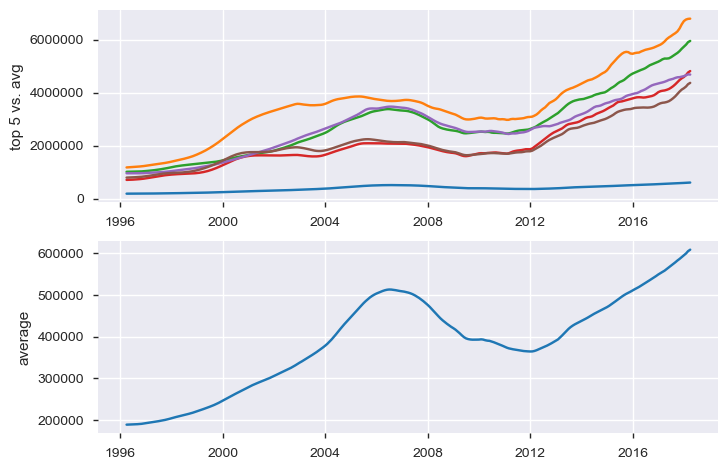

In [38]:
plt.figure()
f, axes = plt.subplots(2, 1);

axes[0].plot(z_df[['us_avg','94027', '90210', '94301', '33480', '94022']]);
axes[0].set_ylabel('top 5 vs. avg');
axes[1].plot(z_df['us_avg'].index, z_df['us_avg']);
axes[1].set_ylabel('average');

All zip codes show a price decrease between 2006 and 2012, but seemingly less extreme than the U.S. average. 

How much do prices fall during the market crash(2006-2012)?

In [39]:
# percent drop between 2004-2012
(z_df['us_avg'].iloc[-168:-120].max()- z_df['us_avg'].iloc[-120:-72].min())/z_df['us_avg'].iloc[-168:-72].max()

0.2895518354956714

In [40]:
for zc in (zcs):
    print ((zc.iloc[-168:-120, :].max()- zc.iloc[-120:-72, :].min())/zc.iloc[-168:-72,:].max())

RegionName
94027    0.228758
dtype: float64
RegionName
90210    0.27338
dtype: float64
RegionName
94301    0.23336
dtype: float64
RegionName
33480    0.297318
dtype: float64
RegionName
94022    0.269083
dtype: float64


The selected dropped between 23 and 30%, and the U.S. average was 29%. The Florida location was the only one dropping more than the U.S. average, by 1%. 

I'll also look at how well the zip codes recovered after the crash.

In [41]:
(z_df['us_avg'].iloc[-120:].max()- z_df['us_avg'].iloc[-120:].min())/z_df['us_avg'].iloc[-120:].max()

0.40102486652016794

In [42]:
for zc in (zcs):
    print ((zc.iloc[-120:, :].max()- zc.iloc[-120:, :].min())/zc.iloc[-120,:].max())

RegionName
94027    1.123919
dtype: float64
RegionName
90210    1.261064
dtype: float64
RegionName
94301    1.731254
dtype: float64
RegionName
33480    0.774142
dtype: float64
RegionName
94022    1.429154
dtype: float64


The average rose by 40% of it's lowest point between 2006 and 2012, and the selected rose between 112 and 177 percent. In this case, the Florida zip code was the one with the most dramatic climb post- market crash. 

To use fbprophet further along, the columns will need to be named 'ds' and 'y'. Using simpler variables make management easier with other things as well so I'll do that now.

In [43]:
# rename columns 'ds' and 'y'(as required for fbprophet, w)
for zc in (zcs):
    zc.index.names = ['ds']
    zc.columns = ['y']
    #zc.reset_index(inplace=True)

# explore/model

### arima the long way- making stationary and fitting

ARIMA models are often used with time series, as they integrate several simpler models into something more complex. The rolling mean, autocorrelation, and seasonality are taken into account to create more robust, quality predictions than using just one of the more naive approaches alone. 

To manually fit a arima model, the data must meet certain assumptions, one being that it is stationary- the rolling mean and rolling standard deviation, and the time series, need to be free of trends. 

In [44]:
#log function helps make data stationary
zc_1 = np.log(zip_1)

In [45]:
#double differencing was needed on this dataset to be transformed to stationary
zc_1= zc_1.diff().diff()

In [46]:
# with differencing, you lose the first value of data
zc_1.dropna(inplace=True)

the adfuller test defaults with an alpha of 0.5, a p-value under 0.5 indicates data is stationary

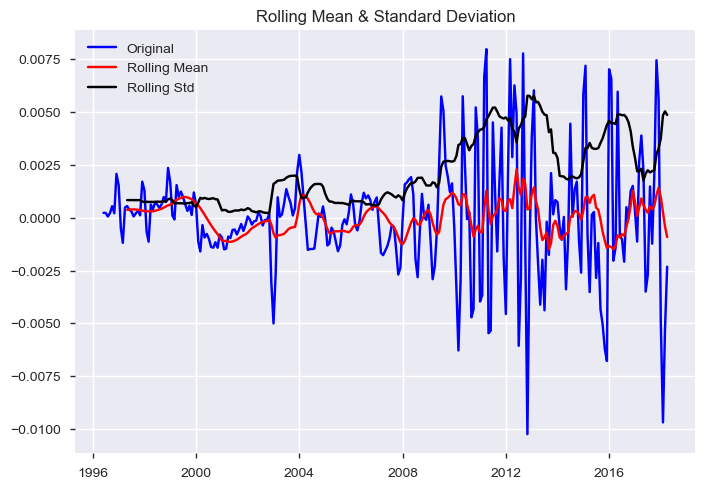

p-value: 0.000004
timeseries is stationary


In [47]:
# plotting series, rolling mean and standard deviation, follwed by adfuller test.
test_stationarity(zc_1.y)

To find the right order for the ARIMA model, we need to find what values to fill for p,d, and q. (For SARIMA:  p,d,q,P,D,Q,s) These are determined based on the autocorrelation, partial autocorrelation, and number of times data was differenced before transformed to stationary.

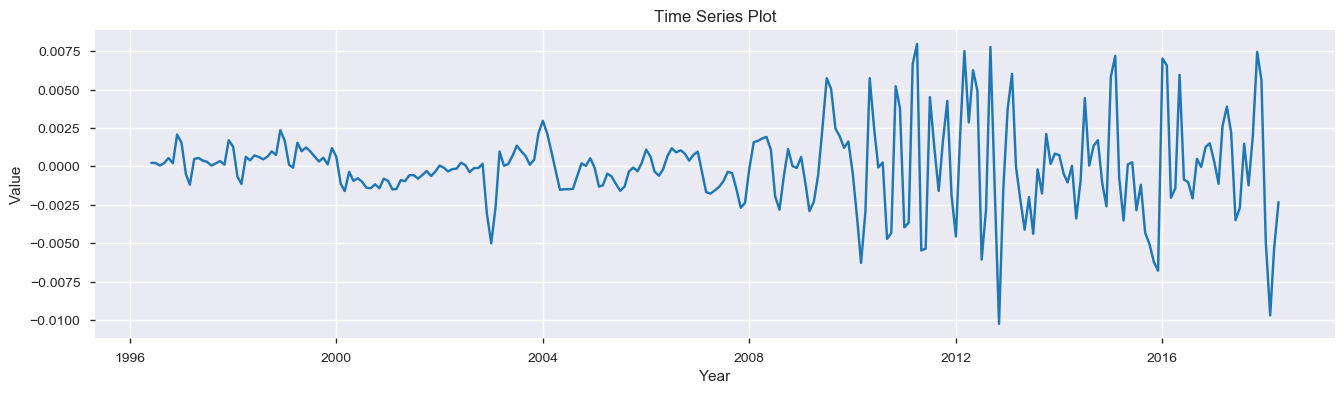

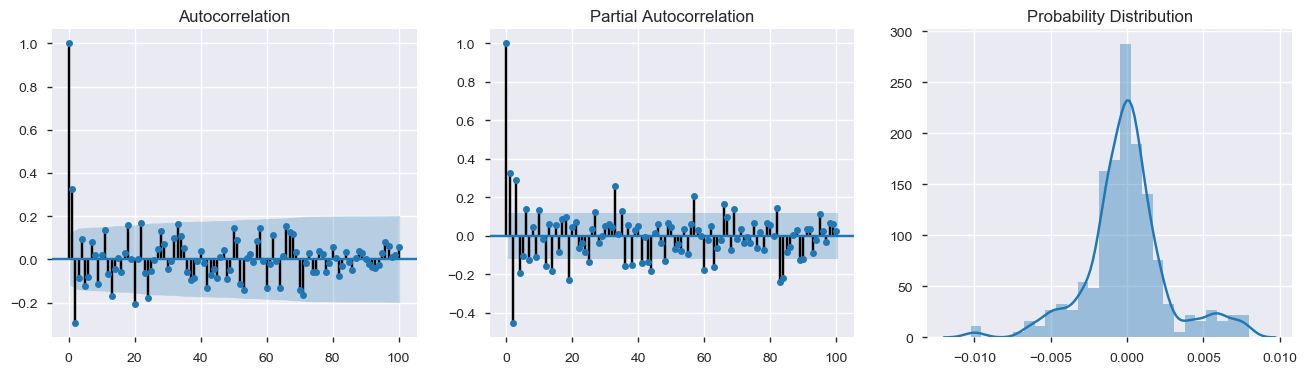

In [48]:
plot_data_properties(zc_1, 100)

for p- we look at the autocorrelation plot. The at 0, the value is at it's most extreme, with all other values falling more closely within the shaded region. So p will be 0.

for d- we use 2, as the data was twice differenced before reaching stationarity.

for q- looking at the partial autocorrelation plot, the first line- at zero, is once again most extreme.

So in this case, I would likely use order: 0,2,0. Adding seasonality might be helpful, too.

I could put more effort into finding for myself the right fit for the SARIMA, but from my few experiences have found the auto_arima tool provided by pyramid python library does a much better job at avoiding under or overfitting, and it's just easier.

Below is what I had originally used to fit with the first zip code, but it didn't turn out to be a good fit.

In [49]:
mod = sm.tsa.statespace.SARIMAX(zip_1
                                ,order=(0, 2, 0)
                               )
results = mod.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2839.815
Date:                Tue, 29 Oct 2019   AIC                           5681.630
Time:                        11:46:07   BIC                           5685.202
Sample:                    04-01-1996   HQIC                          5683.066
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.39e+08   6.15e+06     22.590      0.000    1.27e+08    1.51e+08
Ljung-Box (Q):                      155.45   Jarque-Bera (JB):               349.84
Prob(Q):                              0.00   Pr

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


For a well fit model, you'll want to see a low AIC, and p values below 0.05, ideally. The above may not be the best fit, but for further modeling, I'll be using an automated process.

## zip 94027

Looking at seasonal decompose will show the actual data, trend, seasonality, and residual. Although the models can show the trends and predictions, sometimes these plots will provide additional insight as to how they may perform(or under perform) and what potential complications may be expected.

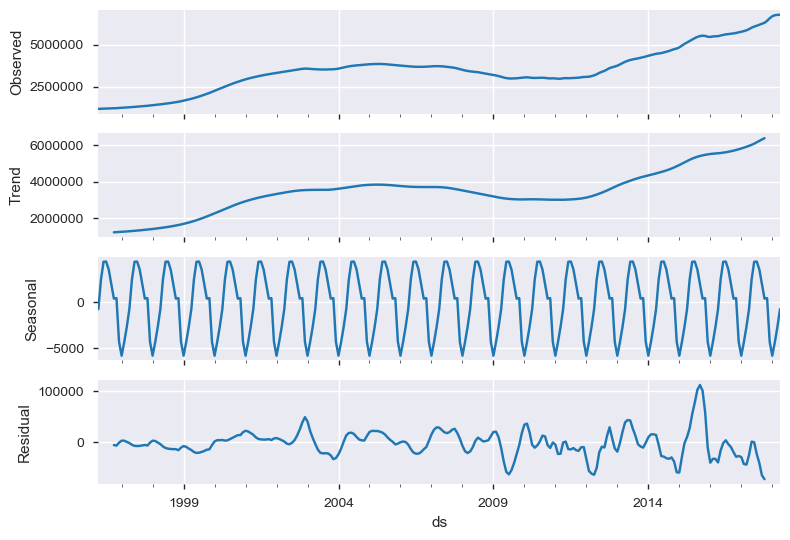

In [50]:
seasonal_decompose(zip_1).plot();

There appears to be seasonality, with one peak per year, and the residuals are greater towards the more recent years.

___
One of the approaches that's integrated in ARIMA, is the rolling average. 
The moving average is a naive approach, using the rolling average of past values to predict the future ones. Despite the simplicity, it plays a part when creating more complex models. Below, the actual values are plotted, alongside the rolling mean trend, based on a 12 period window(12 months). The anomalies, or the values that lie under or over 1 standard deviations from the rolling mean, are indicated in yellow.

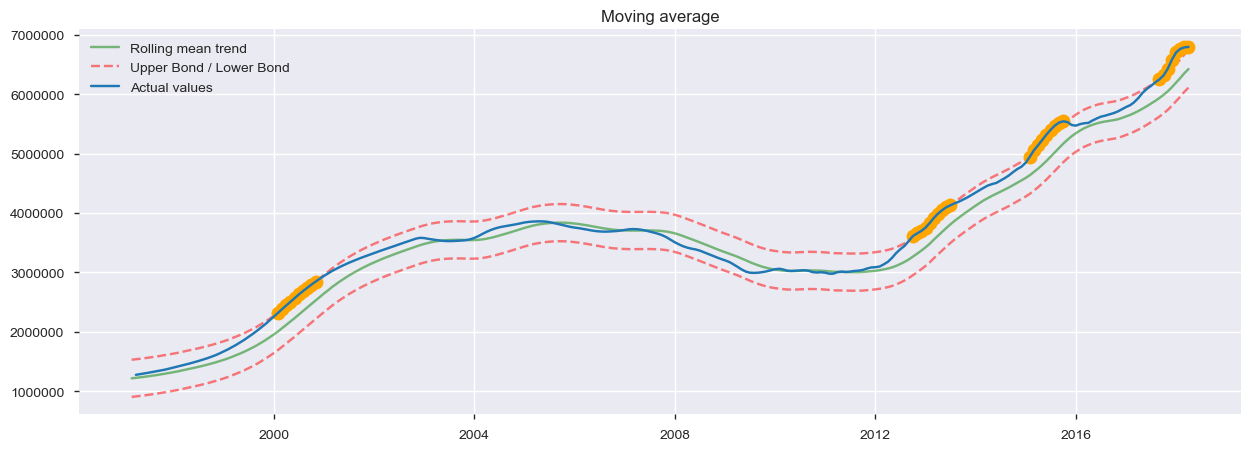

In [51]:
plot_moving_avg(zip_1, window = 12, scale=1)

Most values seem to fit the rolling mean model, although there are increases in some time periods that lie outside the set bounds, especially following the dip between around 2006 and 2011. I would expect to see a similar trend with the other zip codes as well, due to the historical economic events.
___


Although the appropriate values to fit the ARIMA model can be found by making the data stationary and looking at the autocorrelation and partial autocorrelation, and taking into account how many times the data was differenced to be transformed to stationary, and the seasonality factor, the pyramid-arima library offers the convenience of auto_arima. The p,d,q, P, D, Q, and S(or if SARIMA instead of ARIMA) will be used at all are all determined without the need to transform the data or evaluate any plots. 



You can see from the diagnostics that the model fits the appropriate assumptions:

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2839.811
Date:                Tue, 29 Oct 2019   AIC                           5683.622
Time:                        11:46:10   BIC                           5690.767
Sample:                             0   HQIC                          5686.493
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.4068    730.459      0.016      0.988   -1420.266    1443.080
sigma2      1.401e+08   6.25e+06     22.400      0.000    1.28e+08    1.52e+08
Ljung-Box (Q):                      155.45   Jarque-

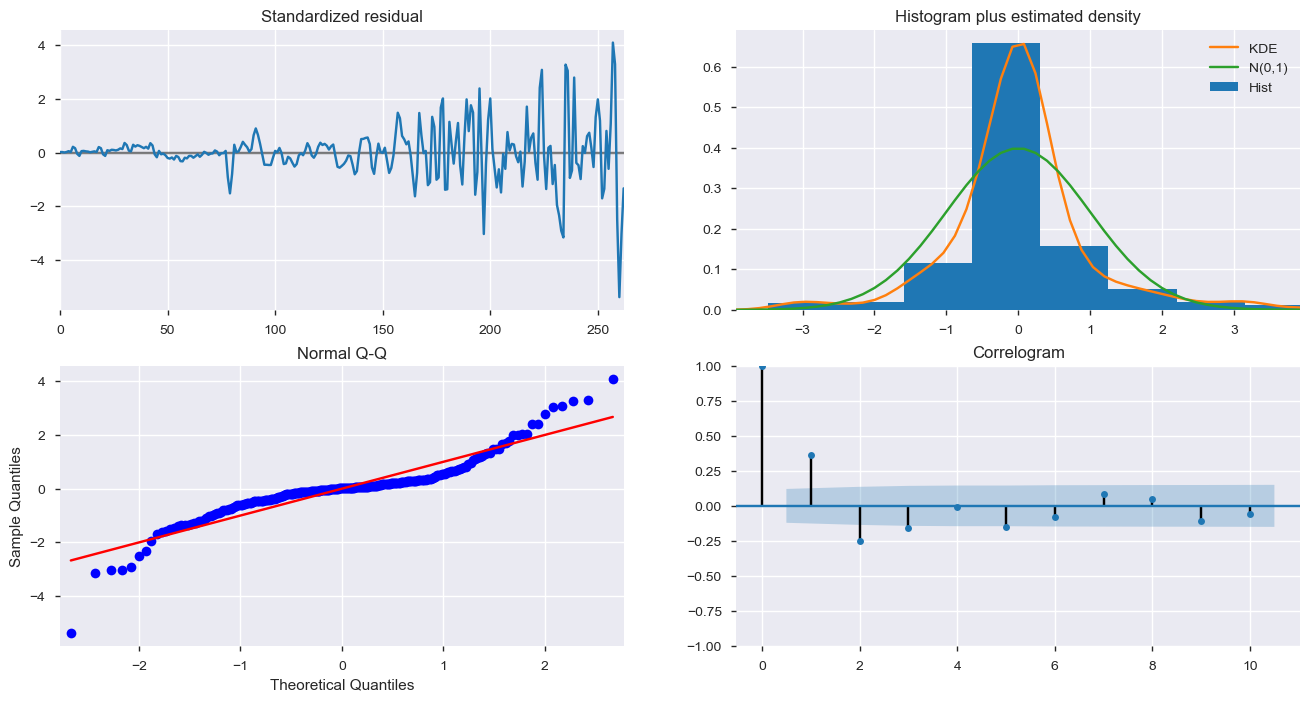

In [52]:
arima_results(zip_1.y)

Using 85% of data as train, and 15% as test, the below plot shows the predicted and actual values, followed by the square root mean error, mean squared percentage error, and explained variance score. A square root mean error and mean squared percentage error closer to 0 is considered more effective. The explained variance score should be closer to 1 to indicate a well performing model.

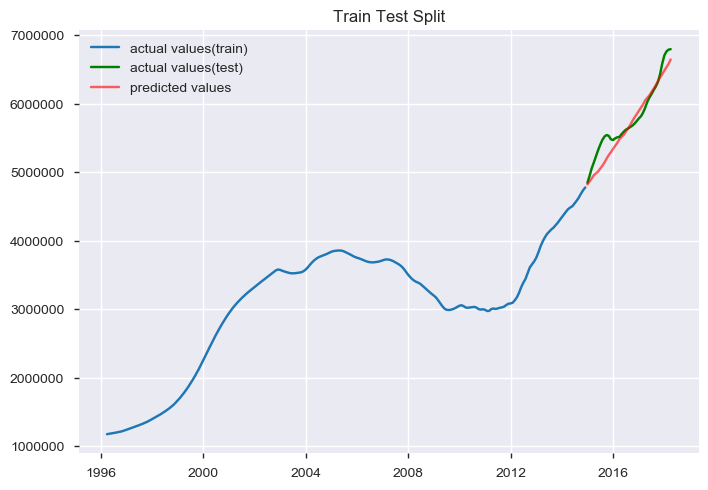

square root mean error: 171598.40766651486
MSE percent: 2.4212308651393295
explained variance score: 0.9243241264527028


In [53]:
auto_arima_tts(zip_1)

A 2.4% mean squared error is good and the model appears to fit well, but without overfitting.

___
Using Sarima to forecast future 2 years:

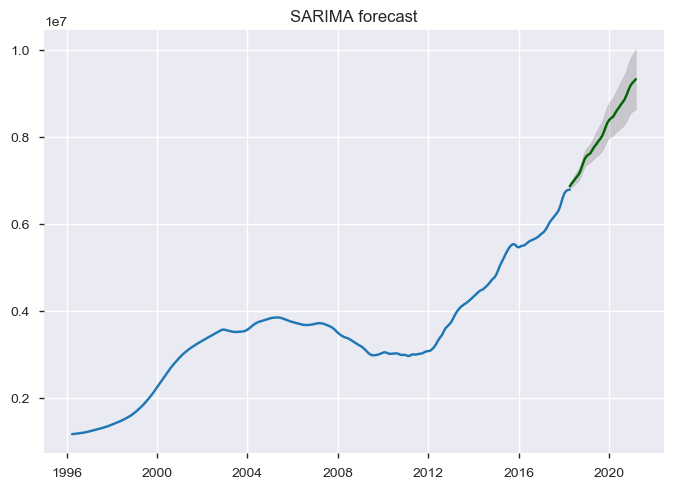

In [54]:
auto_sarima(zip_1)

The projection shows the value may possibly increase by roughly 1.5M in 2 years. Even looking at the lower set interval, it looks fairly certain that there will be an aggressive increase.

## zip 90210

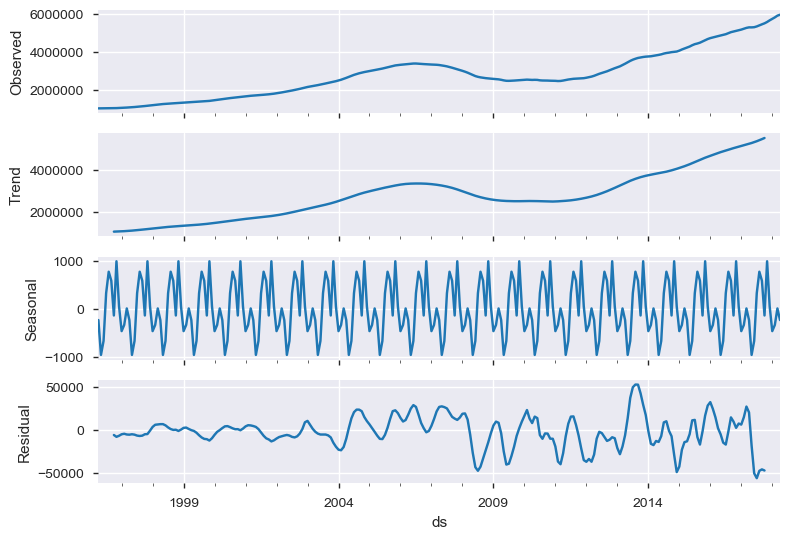

In [55]:
seasonal_decompose(zip_2).plot();

The seasonality on this one is even more dynamic than the previous zip code, the more dramatic variations could mean there's more than one major value increase per year. The residuals also increase notably around 2008, something that may show similar across all of the US zipcodes. This may make it more difficult for the model to find a more narrow prediction interval.

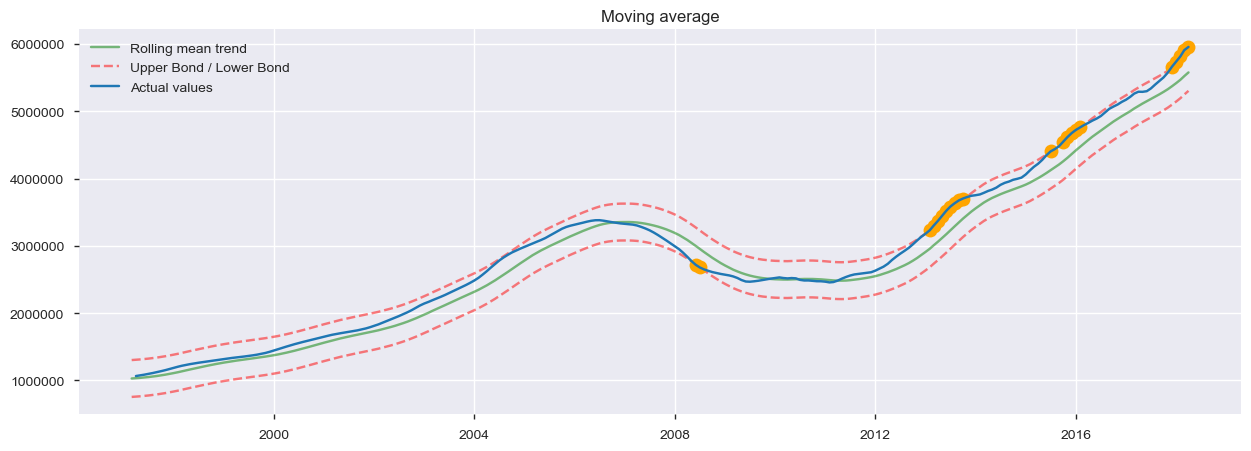

In [56]:
plot_moving_avg(zip_2, 12, scale = 1)

The rolling average model is a fairly good fit here again, with more aggressive increases following 2012, consistent with the seasonal decompose residuals .

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2734.526
Date:                Tue, 29 Oct 2019   AIC                           5473.052
Time:                        11:47:58   BIC                           5480.197
Sample:                             0   HQIC                          5475.923
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    180.2281    492.019      0.366      0.714    -784.111    1144.567
sigma2       6.29e+07   2.95e+06     21.332      0.000    5.71e+07    6.87e+07
Ljung-Box (Q):                       98.86   Jarque-

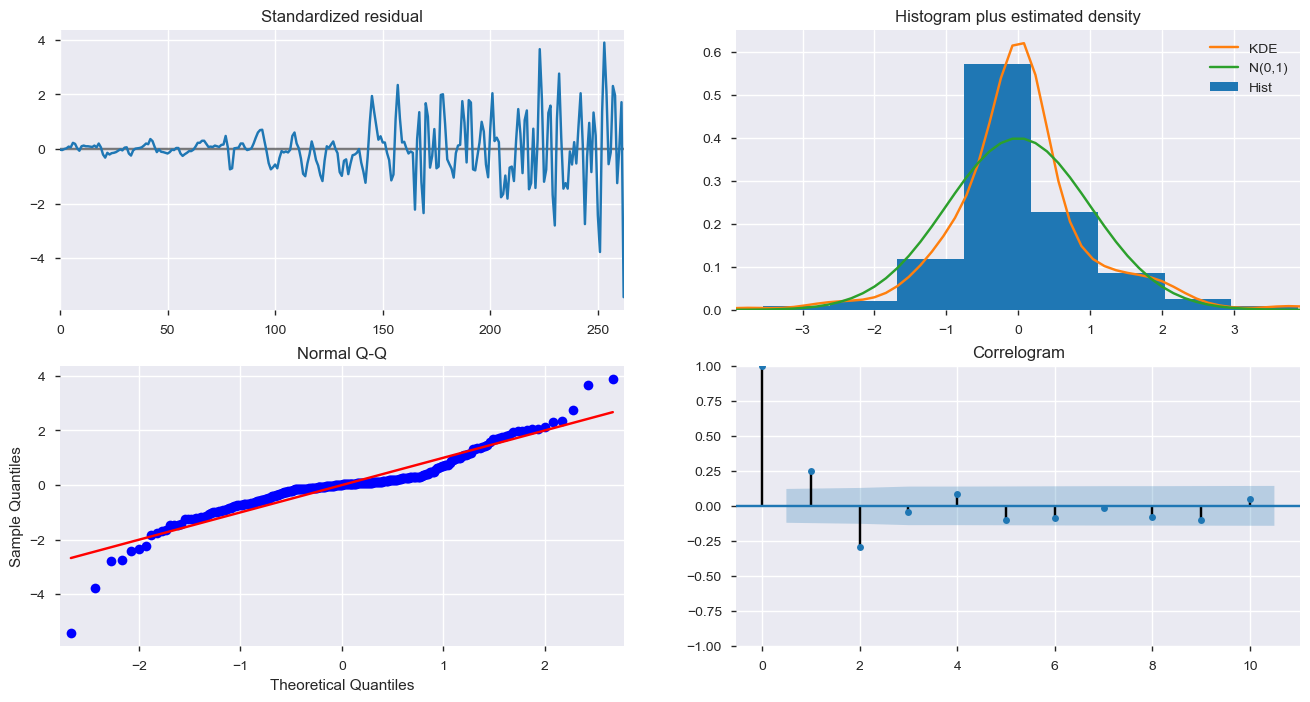

In [57]:
arima_results(zip_2)

The auto arima fit looks good, although the QQ plot indicates there may be some outliers.

Below I will be using 75% of data for training instead of the 85% default I had set, as this model performs poorly with using the 85/15% split. Often, a 75% split is used for train test splits, but because of the unusual dip about half way through the time series, most models performed better with a larger training set. So I find it interesting that the larger train set here didn't prove to be advantageous. 

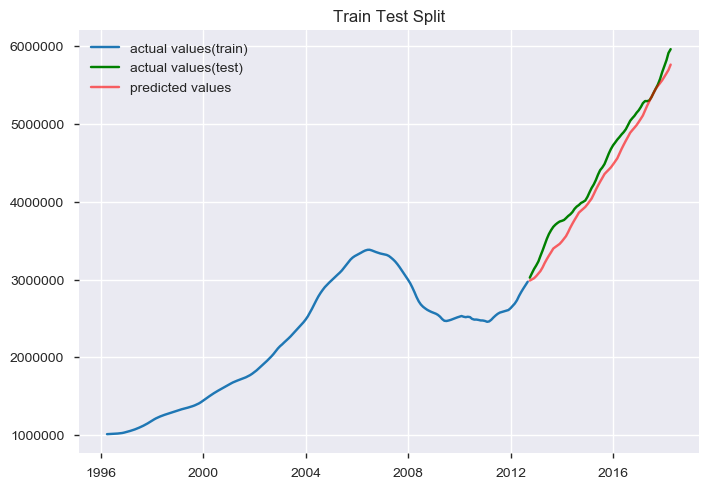

square root mean error: 174067.6865023666
MSE percent: 3.9474824956072205
explained variance score: 0.9917463907292314


In [58]:
auto_arima_tts(zip_2, .75)

The train test split performed well, with an MSE of 4% an explained variance of .99.  
*_(using the 85%, the MSE was 9%, and explained variance .62)_

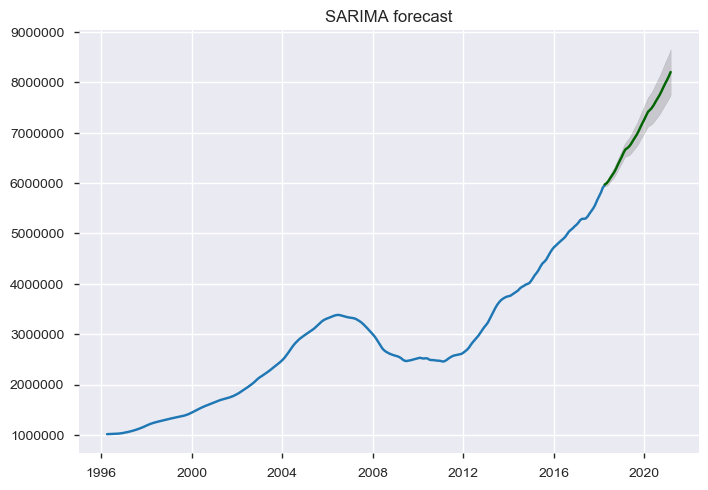

In [59]:
auto_sarima(zip_2)

The prediction shows an increase of nearly 1.5M over the 2 year forecast. Even at the lower end of the interval, the value appears to increase significantly.

## zip 94301

In [60]:
#plot_data_properties(zip_3)

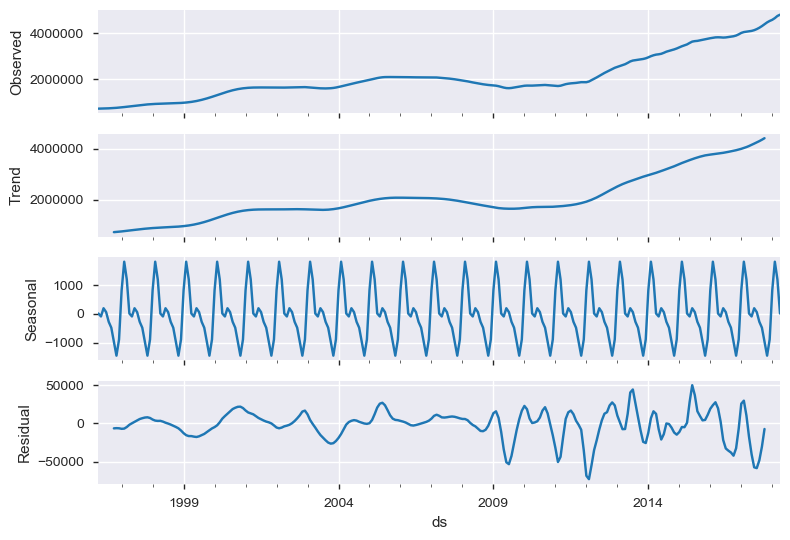

In [61]:
seasonal_decompose(zip_3).plot();

Nothing out of the ordinary here. The seasonality shows a major peak, as well as a minor one following shortly before dropping again. And residuals remain fairly consistent with previous zipcodes.

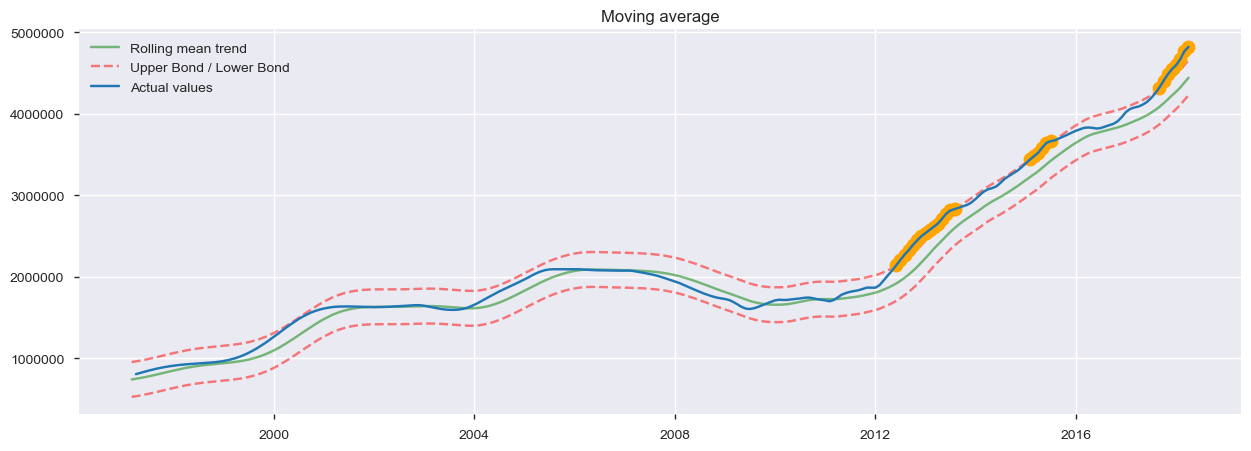

In [62]:
plot_moving_avg(zip_3, window=12, scale= 1)

No anomalies were seen until an aggressive climb after 2012, in the above. If it follows the recent trend, it looks promising for this zip code.

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2740.142
Date:                Tue, 29 Oct 2019   AIC                           5484.284
Time:                        11:50:49   BIC                           5491.428
Sample:                             0   HQIC                          5487.155
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    203.0418    502.721      0.404      0.686    -782.274    1188.357
sigma2      6.564e+07   3.01e+06     21.805      0.000    5.97e+07    7.15e+07
Ljung-Box (Q):                      254.41   Jarque-

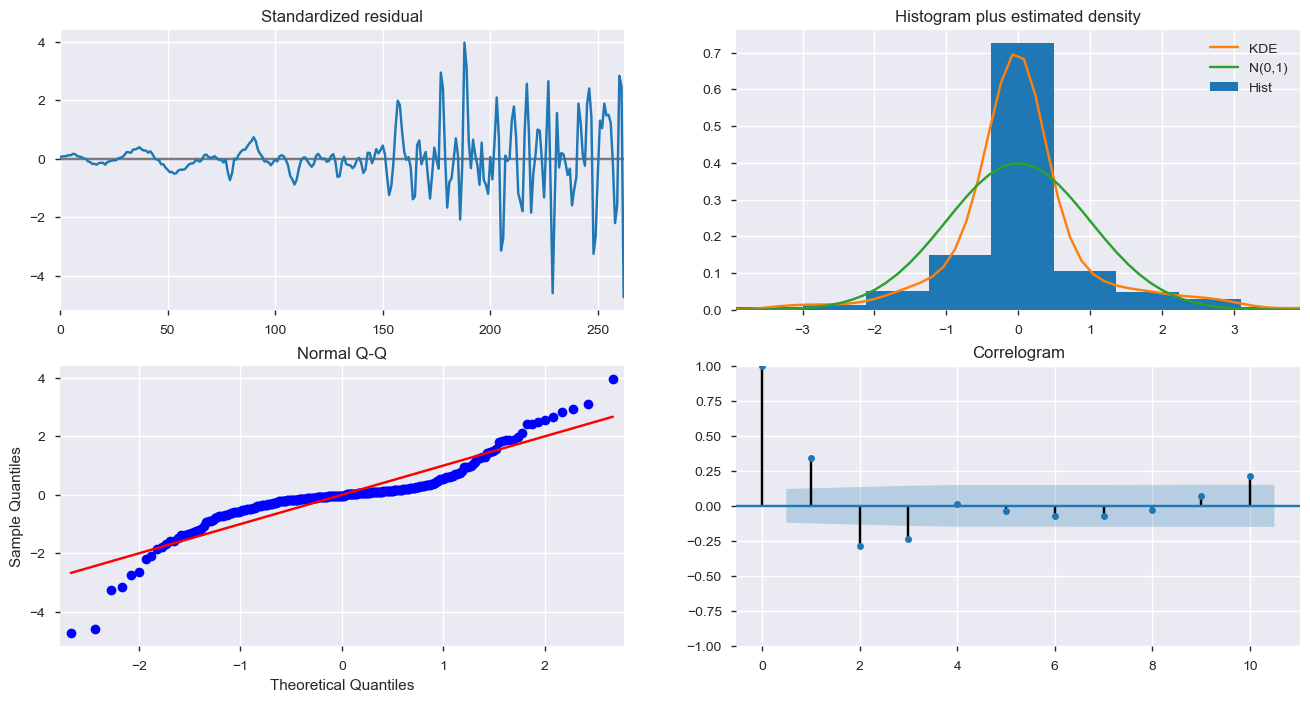

In [63]:
arima_results(zip_3)

Data appears to fit assumptions, and the P value is below 0.05, which indicates a good fit. Although the distribution looks very normal, the QQ plot shows there could be some outliers.

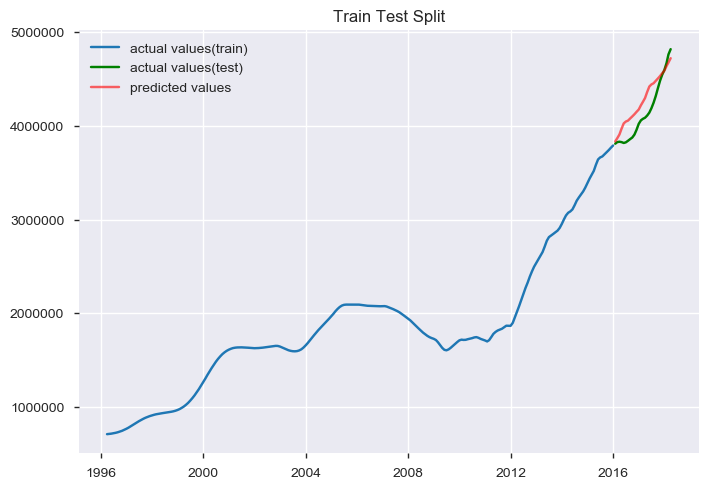

square root mean error: 170186.74396879668
MSE percent: 3.5233241377813633
explained variance score: 0.830476608372686


In [64]:
auto_arima_tts(zip_3, .9)

The MSE is a little higher than som

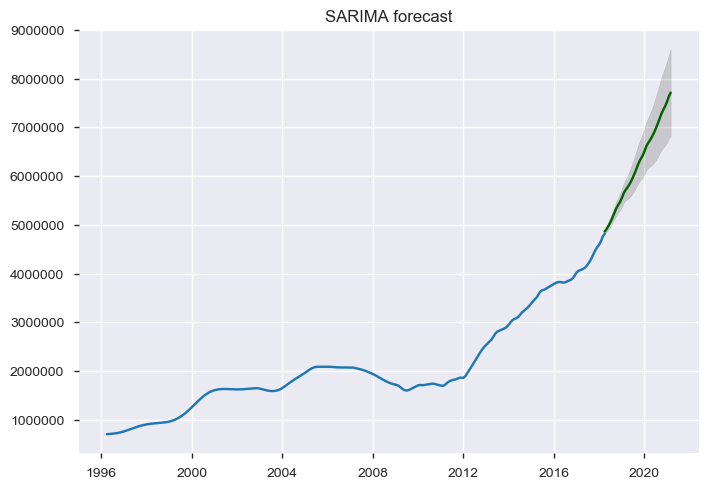

In [65]:
auto_sarima(zip_3)

A 1M-2M increase seems to be the trend with the chosen zip codes. And though the prediction interval widens with time, as is to be expected, it remains to suggest a substantial increase, even at the lower end.

## zip 33480

In [66]:
#plot_data_properties(zip_4)

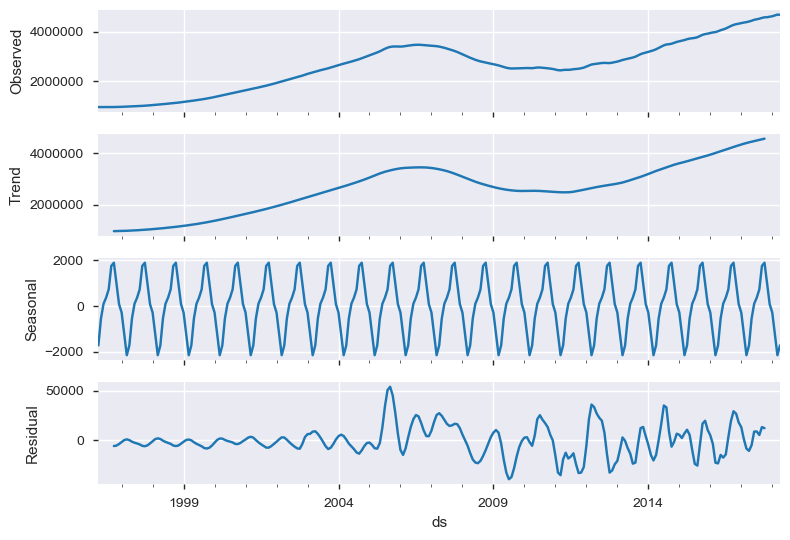

In [67]:
seasonal_decompose(zip_4).plot();

There's just one clear seasonal peak per year, and interestingly, although the residuals widen half way through, it seems they begin to narrow more towards the end.

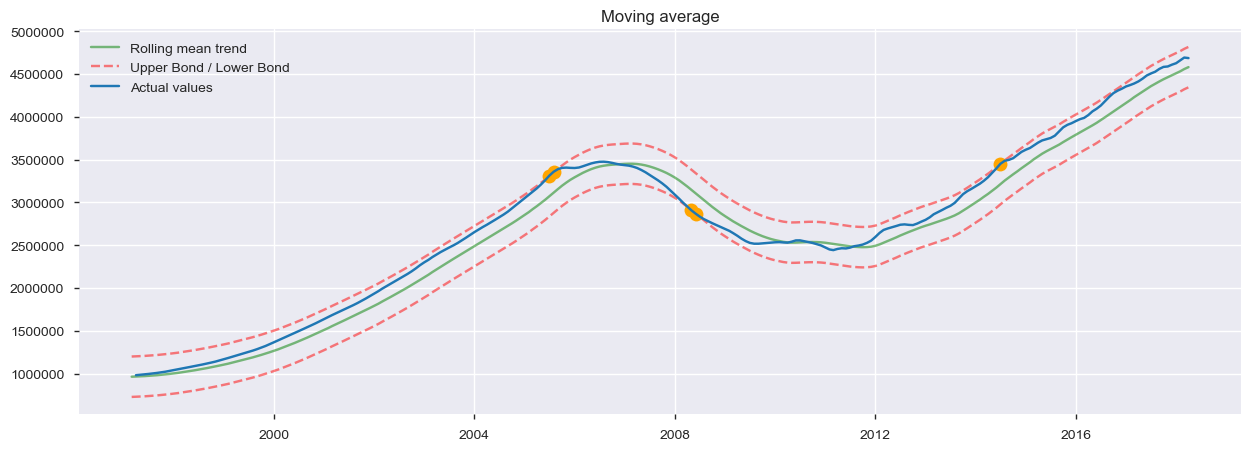

In [68]:
plot_moving_avg(zip_4, 12, scale=1)

This zip codes experiences a brief decrease anomaly around 2008, which hasn't been seen in the previous zip codes, but isn't surprising. There's also less anomalies observed overall than the other zip codes. 

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2969.660
Date:                Tue, 29 Oct 2019   AIC                           5949.319
Time:                        11:51:58   BIC                           5967.199
Sample:                             0   HQIC                          5956.504
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    744.4944    304.979      2.441      0.015     146.747    1342.242
ar.L1          0.9303      0.022     41.624      0.000       0.886       0.974
ma.L1         -0.8813      0.024    -36.430      0.0

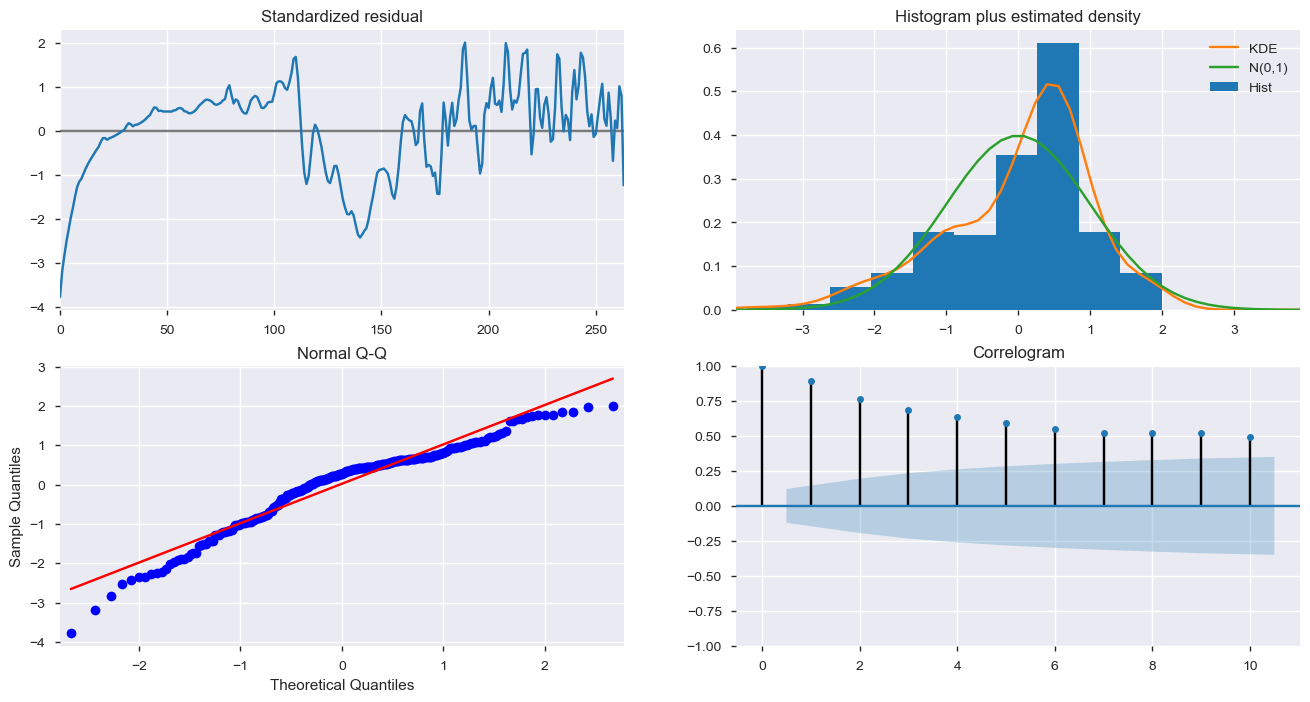

In [69]:
arima_results(zip_4)

The autocorrelation shows to be more positive in this model, but the residuals look a little different. Hopefully this doesn't mean it's a weak model. 

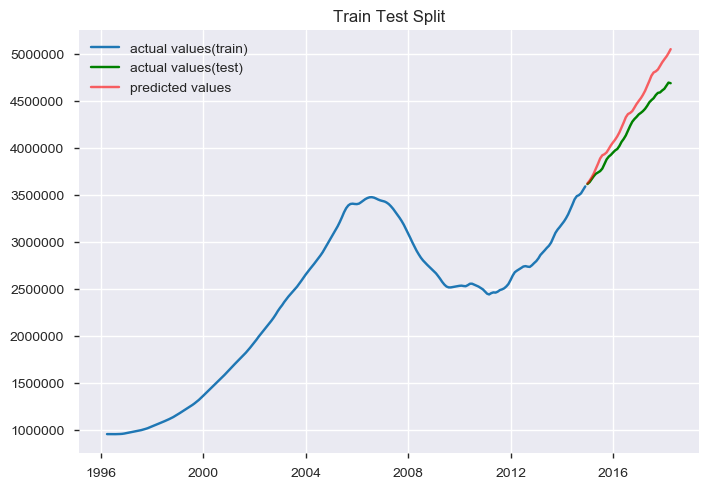

square root mean error: 186977.62986471367
MSE percent: 3.6264795803845082
explained variance score: 0.9551564308274557


In [70]:
auto_arima_tts(zip_4, .85)

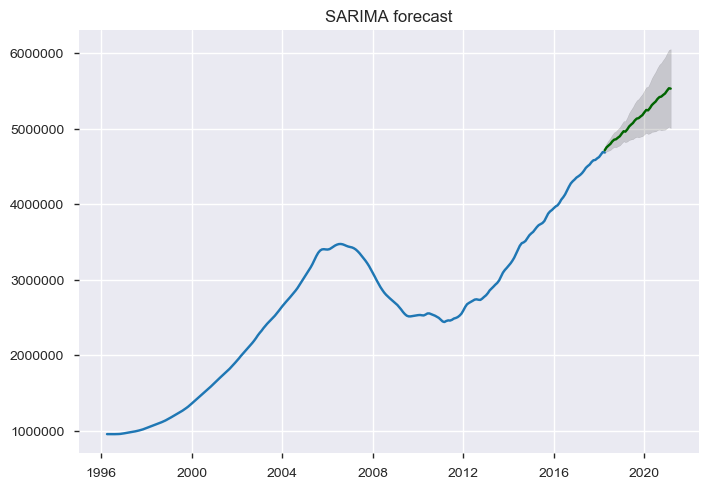

In [71]:
auto_sarima(zip_4)

## zip 94022

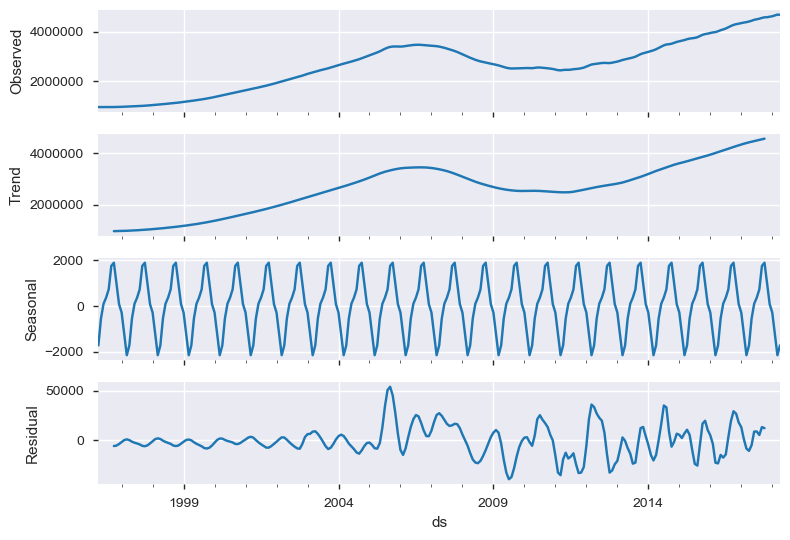

In [72]:
seasonal_decompose(zip_4).plot();

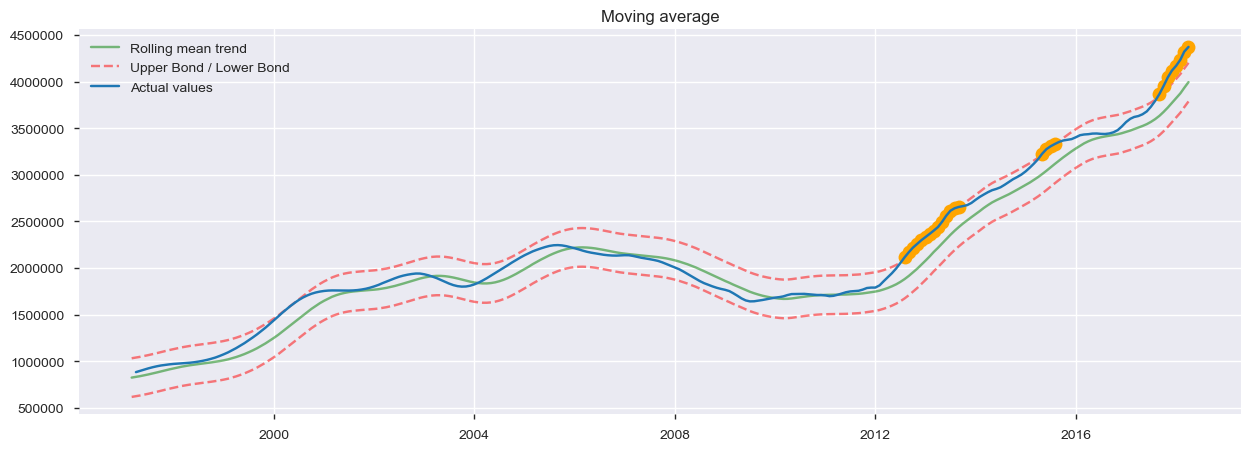

In [73]:
plot_moving_avg(zip_5, 12, scale=1)

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2689.235
Date:                Tue, 29 Oct 2019   AIC                           5382.470
Time:                        11:52:27   BIC                           5389.614
Sample:                             0   HQIC                          5385.341
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    182.1293    419.528      0.434      0.664    -640.130    1004.388
sigma2      4.457e+07   2.14e+06     20.808      0.000    4.04e+07    4.88e+07
Ljung-Box (Q):                      137.10   Jarque-

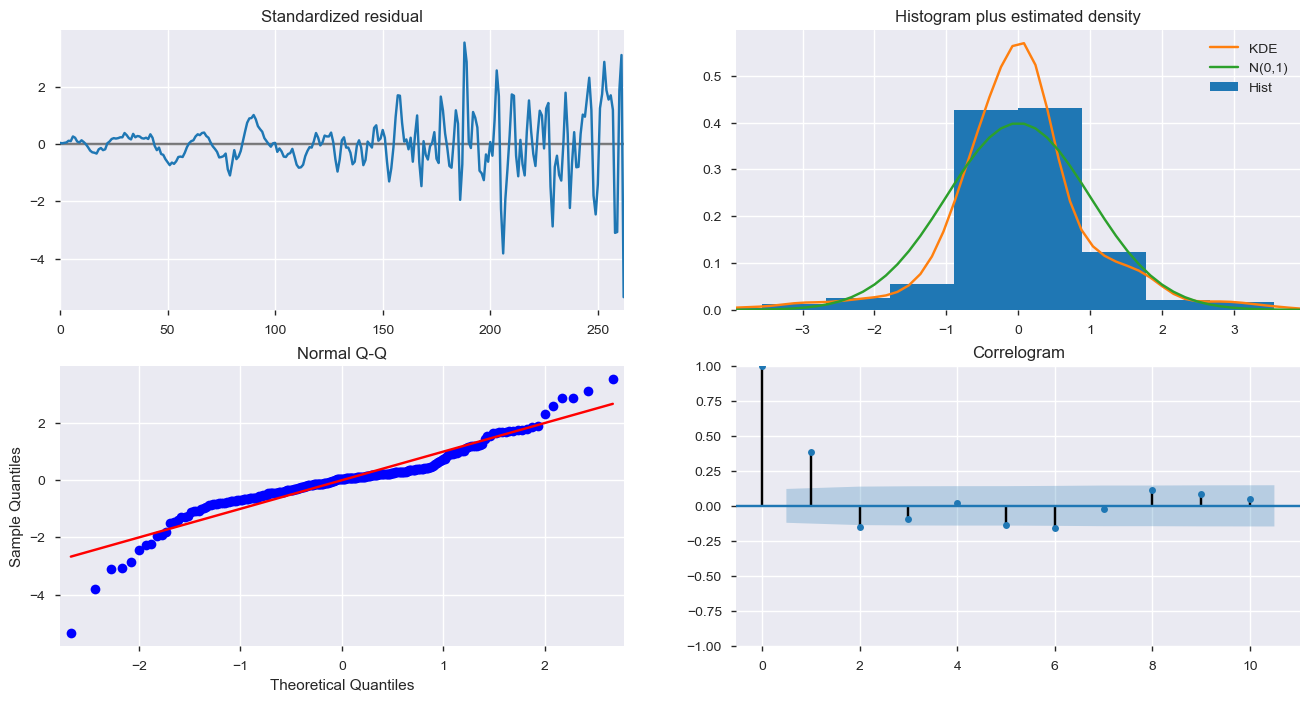

In [74]:
arima_results(zip_5)

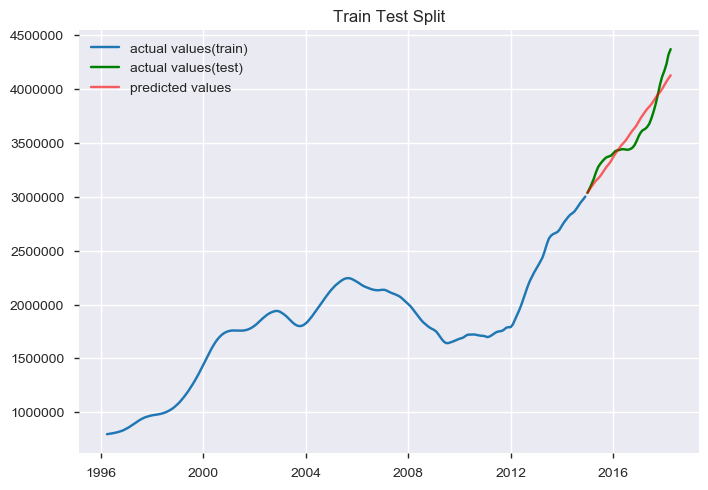

square root mean error: 114623.99065178494
MSE percent: 2.666512702212995
explained variance score: 0.8736292846404772


In [75]:
auto_arima_tts(zip_5, .85)

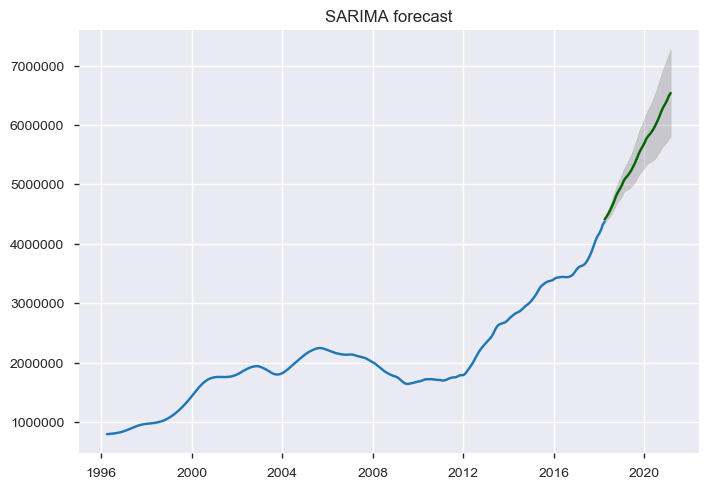

In [76]:
auto_sarima(zip_5)

## ignore- the 'worst' zip code: 95961

I took a look at the lowest scored zip code to see how it compared to the ones I chose. It's found in Olivehurst, CA. It's located north of Sacramento.

*_Originally the lowest scored zip code was found to be one located in Austin, TX. Knowing it as a major city made it an unexpected find, and after some research I concluded the data was backwards, which raises concern about the rest of the data being accurate._

In [77]:
## reversing the values of 78735 vertically
#z_df['78735'] = z_df['78735'].values[::-1]

In [78]:
worst_zip = z_df[['95961']].copy()
worst_zip.index.names = ['ds']
worst_zip.columns = ['y']

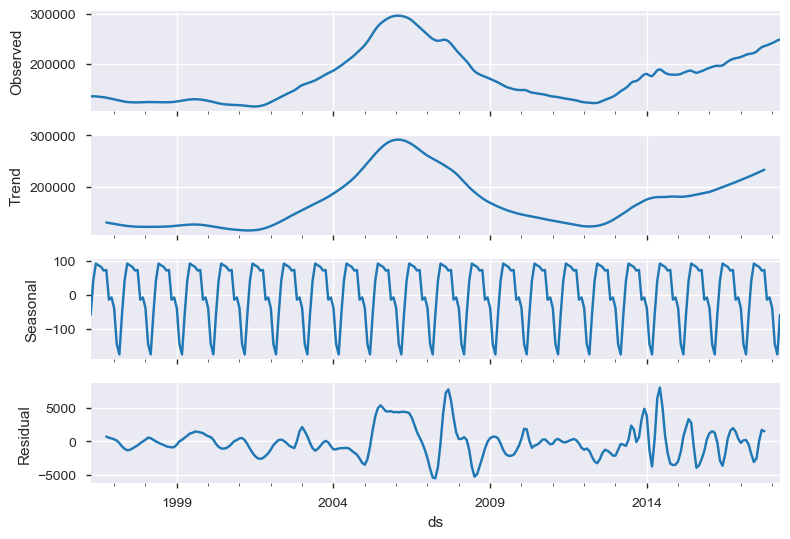

In [79]:
seasonal_decompose(worst_zip).plot();

The trend is clearly not looking as positive here, and the residuals might be a little funkier than the other ones.

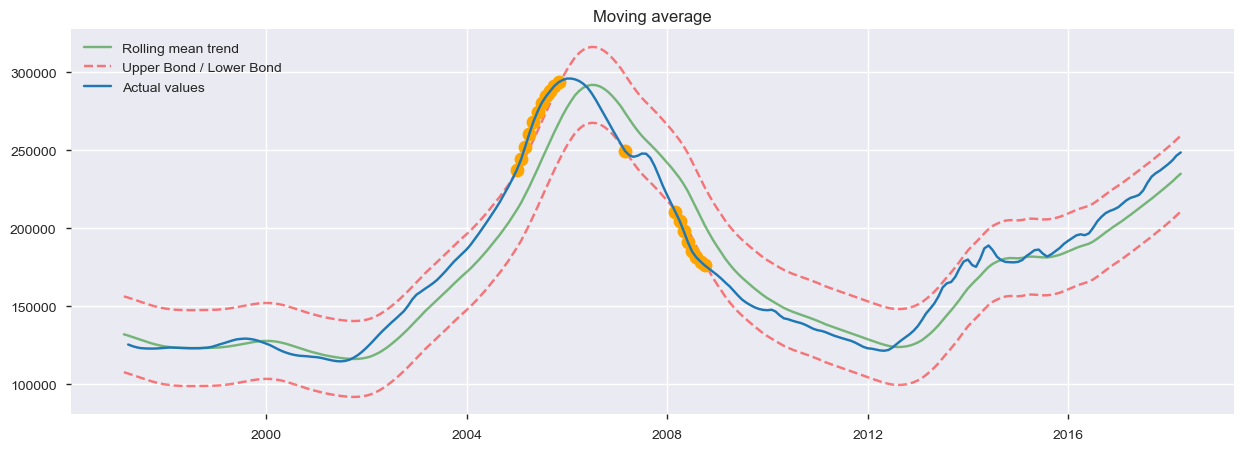

In [80]:
plot_moving_avg(worst_zip, scale=1)

The drop in price between 2006 and 2012 was so severe, the value dipped below what it was in year 2000, and still hasn't reached it's value from 2006.

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -2434.267
Date:                Tue, 29 Oct 2019   AIC                           4882.535
Time:                        11:55:12   BIC                           4907.566
Sample:                             0   HQIC                          4892.593
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -107.8555     57.449     -1.877      0.060    -220.453       4.742
ar.L1          0.7215      0.089      8.124      0.000       0.547       0.896
ar.L2          0.0006      0.011      0.059      0.9

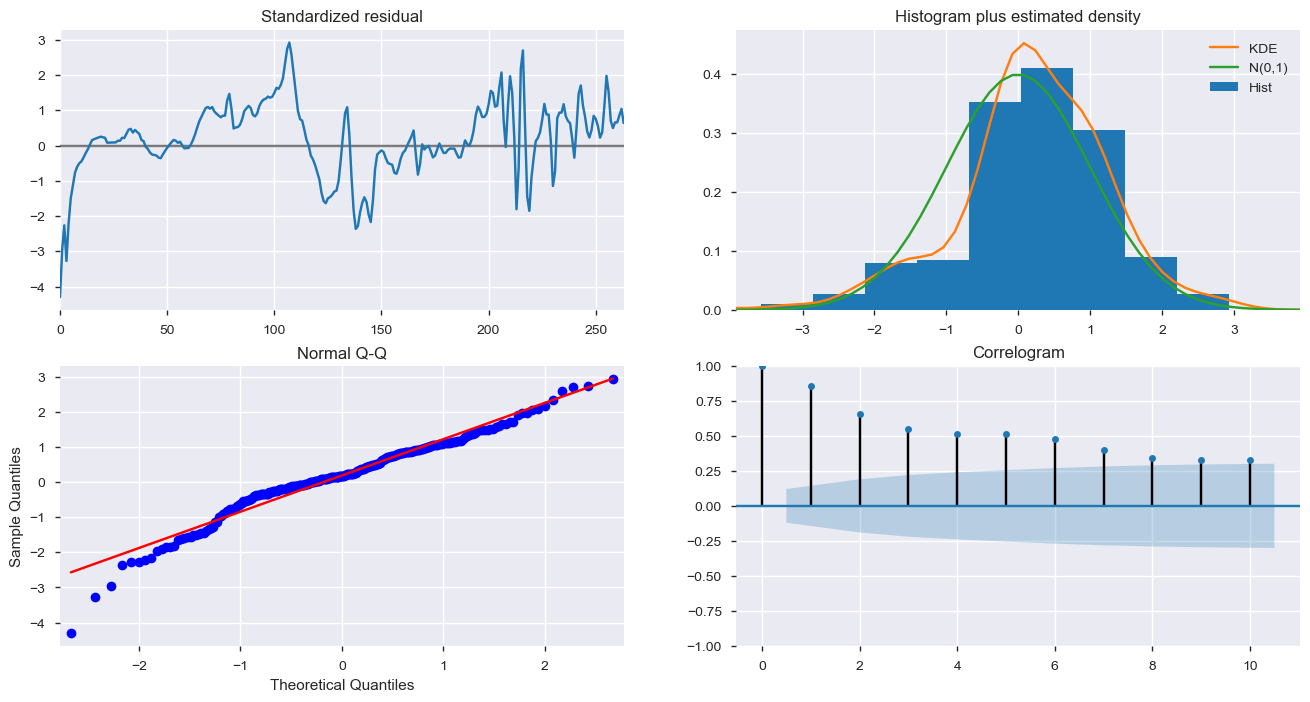

In [81]:
arima_results(worst_zip)

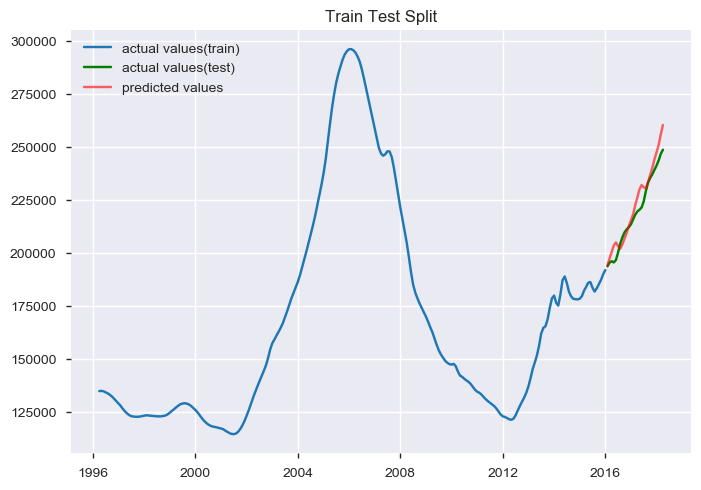

square root mean error: 5660.655648976175
MSE percent: 2.024983236760766
explained variance score: 0.9517858867033612


In [82]:
auto_arima_tts(worst_zip, .9)

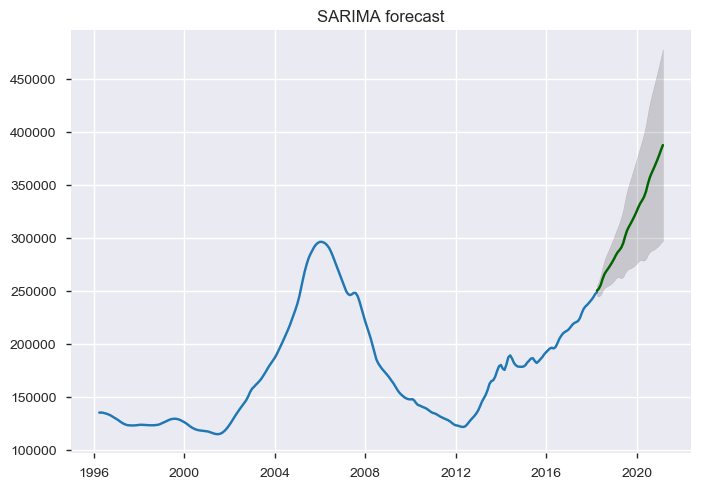

In [83]:
auto_sarima(worst_zip)

# fbprophet

In [84]:
#stop

In [85]:
# imports for fbprophet
import fbprophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly, plot_yearly, plot_cross_validation_metric
import plotly.offline as py
py.init_notebook_mode()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Facebook prophet is also often used to forecast time series data, and requires little prep, while maintaining quality forecasts. As with all forecasting, the confidence interval widens with time. I'll be using a 95% prediction interval for the facebook prophet forecasts, and a 24 period(2 years) forecast to keep the confidence narrow.

## 94027

In [86]:
fb_proph(zip_1, periods = 36)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.79M is the average price in April 2018, and in 3 years it's predicted to be 8.258M. The 95% prediction interval is between 7.45M and 9.24M. You could expect between a 660K to 2.45M return on a home if bought at average market price for the area in 2018 and sold 3 years later.

INFO:fbprophet:Making 7 forecasts with cutoffs between 2006-04-04 00:00:00 and 2015-04-02 00:00:00


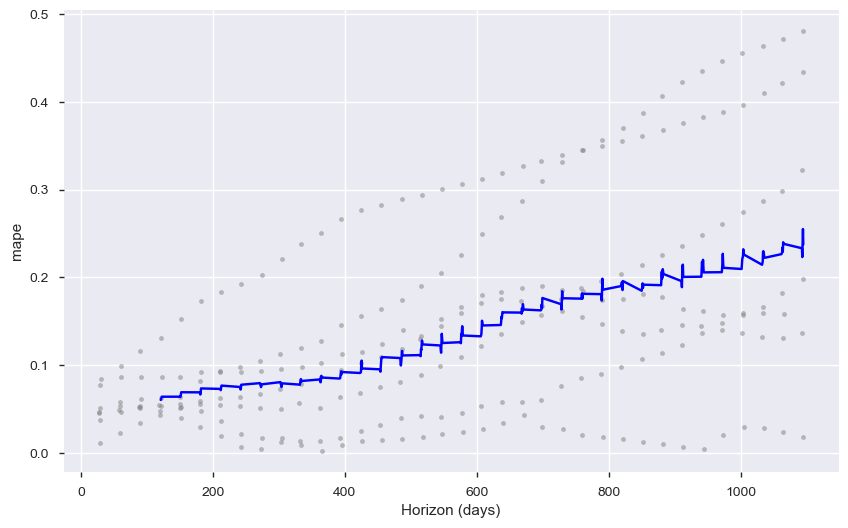

In [87]:
proph_metrics(m)

As with all forecasts, the further into the unknown the prediction, the larger the error. For the first year, the error is under 10%, but climbs to 25% by the end of the third year of forecast.

In [88]:
# plot predicted profit
#zip_1.tail(1)
#pred_return(6796500, preds)

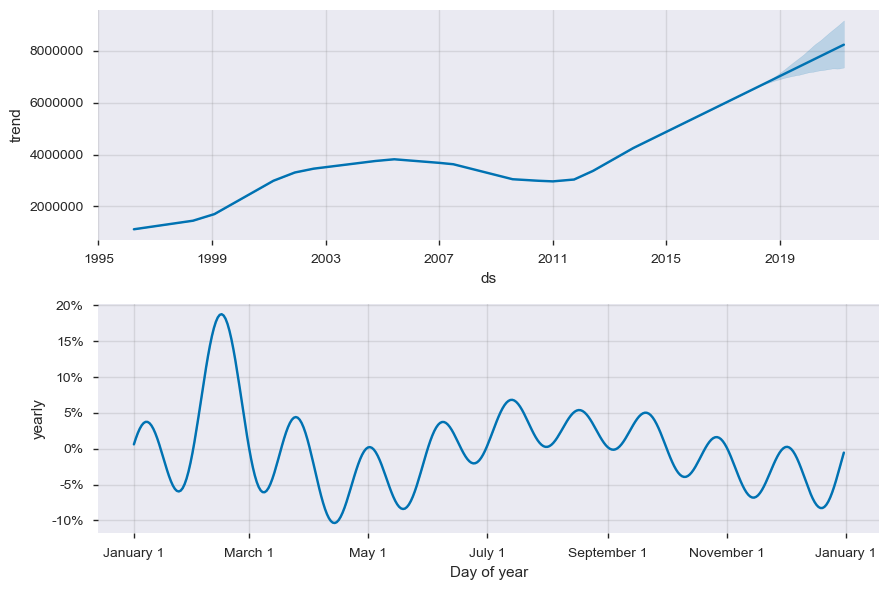

In [89]:
m.plot_components(forecast);

The yearly shows that the values rise to nearly 20% more than average in February, but then immediately dips below average between March and May. This would be important for investors to know. The rest of the variance doesn't look as significant.

From the gathered data, April is the best time to buy, and February would be the best time to sell, potentially making 600k more than other months of the year. 

## 90210

In [90]:
fb_proph(zip_2, periods=36)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The price in April 2018 is 5.95M, and is forecasted to be 7.3M in 3 years. This would mean a profit of about 1.3M for investors, if bought and sold appropriately.

INFO:fbprophet:Making 7 forecasts with cutoffs between 2006-04-04 00:00:00 and 2015-04-02 00:00:00


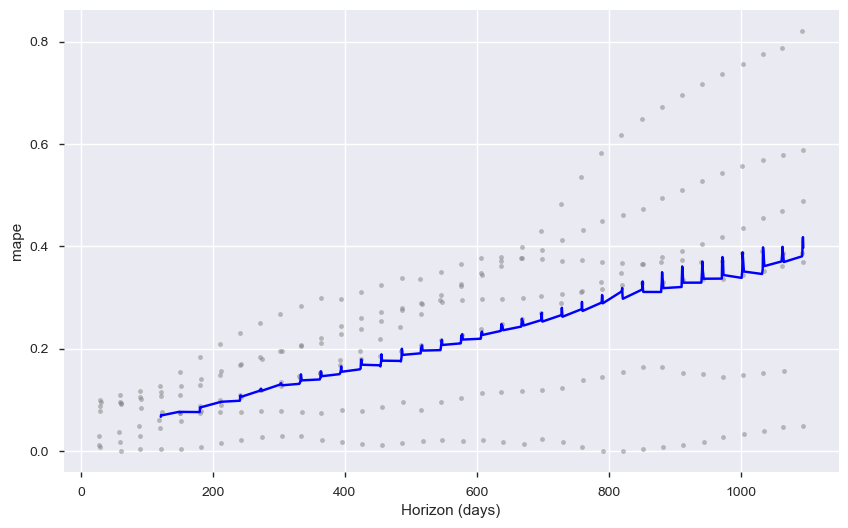

In [91]:
proph_metrics(m)

The error is higher on this model than the prior one. Some tweaks could be made if wanting to improve the mape score, but the series data here may just be more unpredictable.

In [92]:
# #plot predicted profit
# zip_2.tail(1)
# pred_return(5956700, preds)

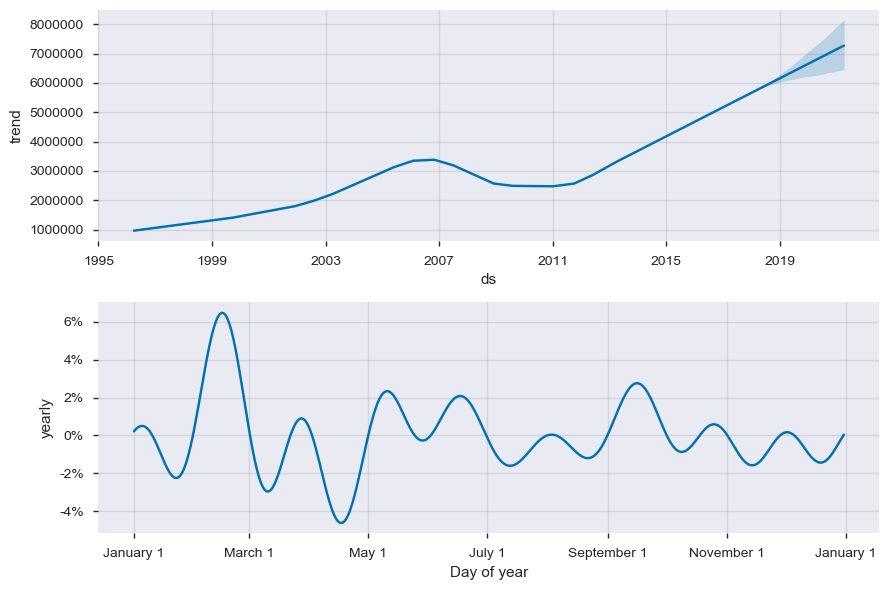

In [93]:
m.plot_components(forecast);

The seasonality isn't as strong here, seeing as the values don't typically deviate by more than 6%. The month of February is once again hottest for this zip code, and April low. The rest of the year, the value doesn't seem to variate much.

## 94301

In [94]:
fb_proph(zip_3, periods=36)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The value is predicted to grow from 4.8M to 5.8M in 3 years, which would mean an amazing 20% increase.

INFO:fbprophet:Making 7 forecasts with cutoffs between 2006-04-04 00:00:00 and 2015-04-02 00:00:00


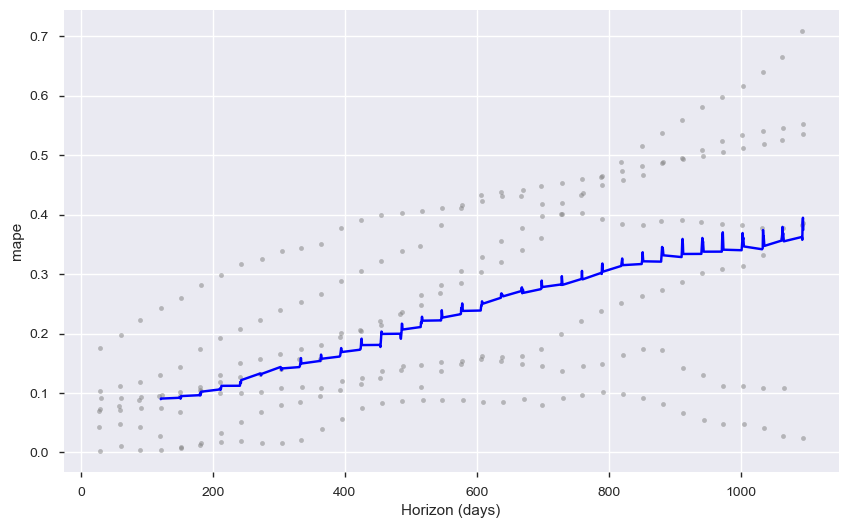

In [95]:
proph_metrics(m)

In [96]:
# # plot predicted profit
# zip_3.tail(1)
# pred_return(4818400, preds)

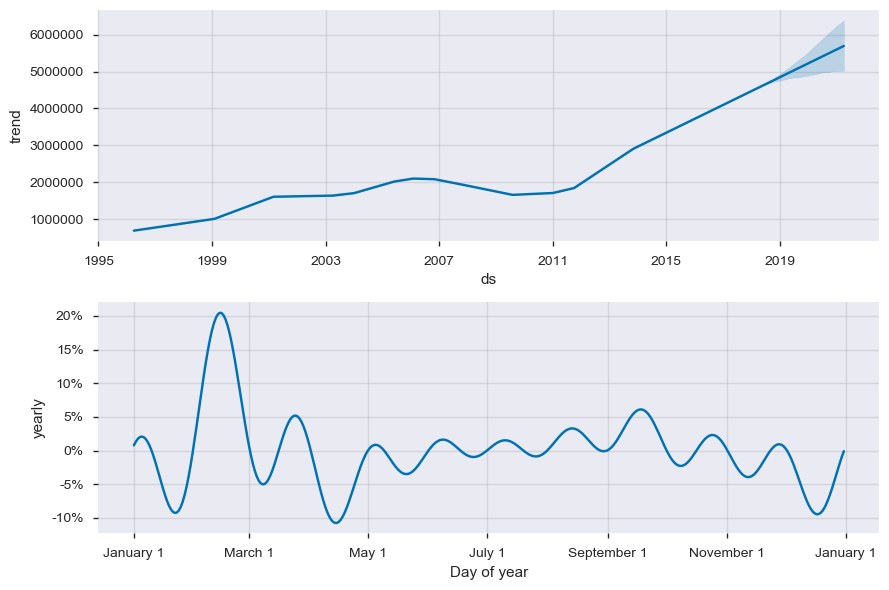

In [97]:
m.plot_components(forecast);

## 33480

In [98]:
fb_proph(zip_4, periods=36)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 7 forecasts with cutoffs between 2006-04-04 00:00:00 and 2015-04-02 00:00:00


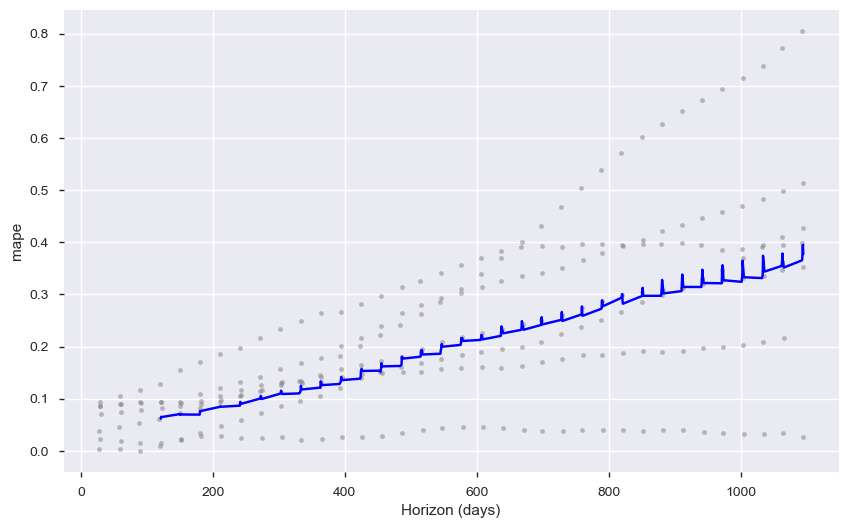

In [99]:
proph_metrics(m)

In [100]:
# #plot predicted profit
# zip_4.tail(1)
# pred_return(4686200, preds)

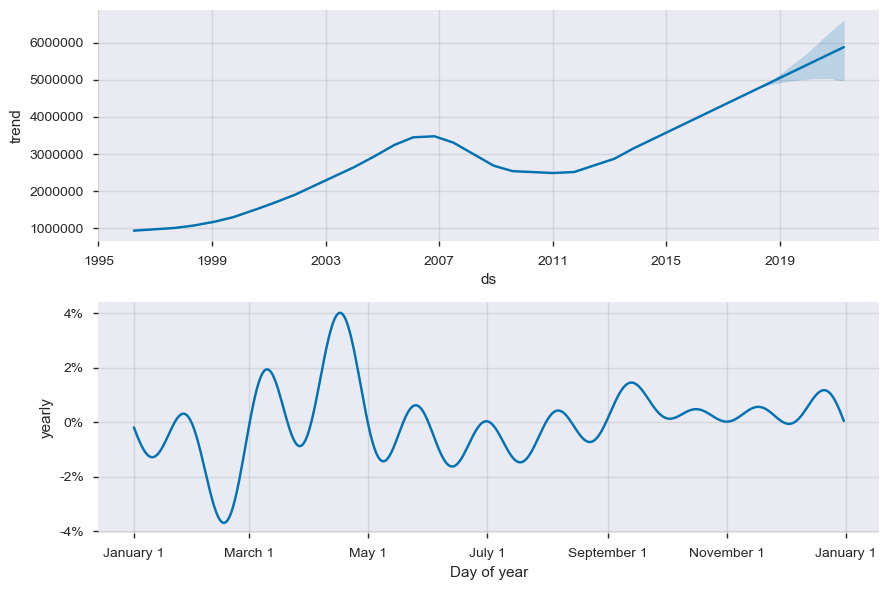

In [101]:
m.plot_components(forecast);

## 94022

In [102]:
fb_proph(zip_5, periods=36)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 7 forecasts with cutoffs between 2006-04-04 00:00:00 and 2015-04-02 00:00:00


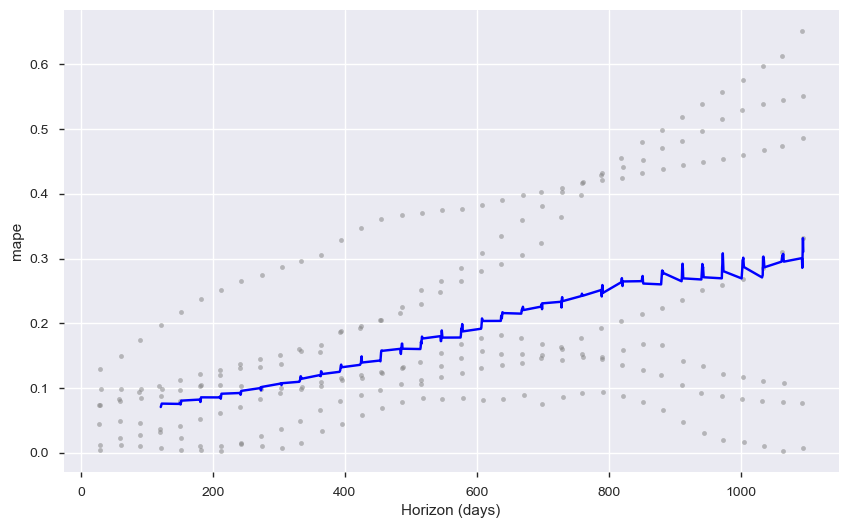

In [103]:
proph_metrics(m)

In [104]:
# #plot predicted profit
# zip_5.tail(1)
# pred_return(4372600, preds)

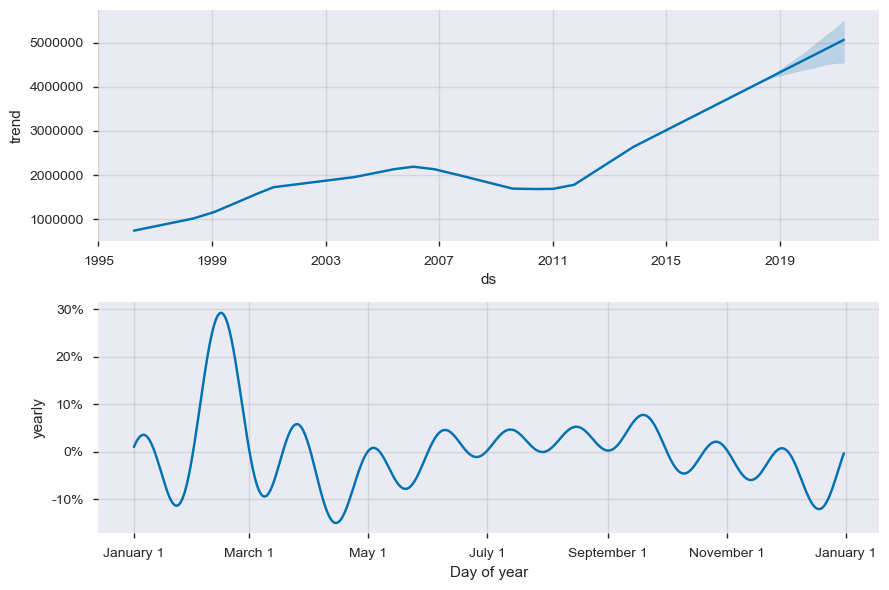

In [105]:
m.plot_components(forecast);

# conclusion

Although D.C, California, and Hawaii have the highest current value properties, on average, 4 of the chosen zip codes landed in California, 3 of which were in 13 miles proximity. The other zip code was located in Florida. The California zip codes had similar characteristics in regards to autocorrelation seasonality, and trend. Their value fell less during the market crash than average, and also rose at a much higher degree. The Florida zip code, surprisingly, fell by a larger percent, but bounced back much more enthusiastically than the California ones. 

All selected zip codes are valued between 4.3M and 6.8M and forecasted to increase by between 800k to 1.5M in the next 3 years.

One problem I encountered, because of the elimination of data with na values, some of the top priced zip codes in the original dataset were excluded from the analysis that could also have potential for high profit.


All zip codes' value peaked in February, except for the one in Florida, which on the contrary, typically drops in value in February. It would be advised to invest in real estate in March, April, or sometimes December, and of course sell in the the peak season, which is April in the Florida zip code and February in the California ones. 